In [167]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import random
from einops.layers.torch import Rearrange
from einops import rearrange

from typing import Any, Dict, Tuple, Optional
from game_mechanics import (
    ChooseMoveCheckpoint,
    ShooterEnv,
    checkpoint_model,
    choose_move_randomly,
    human_player,
    load_network,
    play_shooter,
    save_network,
)
from tqdm.notebook import tqdm

from functools import partial
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from copy import deepcopy
from functools import partial

from utils import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [131]:
TEAM_NAME = "Hristo"  # <---- Enter your team name here!
assert TEAM_NAME != "Team Name", "Please change your TEAM_NAME!"

In [145]:
device = 'cuda:0'

In [146]:
def choose_move(state, neural_network: nn.Module) -> int:
    probs = neural_network(state.to(device))
    probs = probs.cpu().detach().numpy()
    move = np.random.choice(range(6), p=probs)
    return int(move)

In [197]:
policy = nn.Sequential(
    nn.Linear(24, 1000),
    nn.LeakyReLU(),
    nn.Linear(1000, 1000),
    nn.LeakyReLU(),
    nn.Linear(1000, 6),
    nn.Softmax(dim=-1)
)

V = nn.Sequential(
    nn.Linear(24, 1000),
    nn.LeakyReLU(),
    nn.Linear(1000, 1),
    nn.Tanh()
)



gamma = 0.99
lamda = 0.99
erm = EpisodeReplayMemory(gamma, lamda)
optimizer_policy = torch.optim.Adam(policy.parameters(), lr=0.0005)
optimizer_value = torch.optim.Adam(V.parameters(), lr=0.0001)

episodes_per_stage = 1000
batch_size = 1000
n_stages = 10
gradient_steps = 3
env = ShooterEnv(opponent_choose_move=choose_move_randomly)

policy.to(device)
V.to(device)

Sequential(
  (0): Linear(in_features=24, out_features=1000, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=1000, out_features=1, bias=True)
  (3): Tanh()
)

In [180]:
wtf = erm.current_episode[erm.current_episode.value.isna()].observation.values

In [182]:
wtf = torch.stack(tuple(wtf))

In [183]:
wtf.shape

torch.Size([4, 35])

In [190]:
wtf.isnan()

tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False,  True,  True, False, False, False,
         False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False,  True,  True, False, False, False,
         False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False,  True,  True, False, False, False,
         False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, Fal

In [186]:
wtf

tensor([[-8.3216e-01,  8.2222e-01, -2.5882e-01, -9.6593e-01, -8.3216e-01,
          8.2222e-01, -2.5882e-01, -9.6593e-01, -1.0000e+00, -1.0000e+00,
          0.0000e+00,  1.0000e+00, -1.0000e+00, -1.0000e+00,  0.0000e+00,
          1.0000e+00, -1.0000e+00, -1.0000e+00,  0.0000e+00,  1.0000e+00,
         -1.0000e+00, -1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
                 nan,         nan,  1.0000e+01,  1.0000e+01,  1.8299e+00,
          1.8299e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-8.3216e-01,  8.2222e-01, -2.5882e-01, -9.6593e-01, -8.3216e-01,
          8.2222e-01, -2.5882e-01, -9.6593e-01, -1.0000e+00, -1.0000e+00,
          0.0000e+00,  1.0000e+00, -1.0000e+00, -1.0000e+00,  0.0000e+00,
          1.0000e+00, -1.0000e+00, -1.0000e+00,  0.0000e+00,  1.0000e+00,
         -1.0000e+00, -1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
                 nan,         nan,  1.0000e+01,  1.0000e+01,  1.8299e+00,
          1.8299e+00,  0.0000e+00,  0

In [185]:
V(wtf.to(device))

tensor([[nan],
        [nan],
        [nan],
        [nan]], device='cuda:0', grad_fn=<TanhBackward0>)

In [199]:
loss_policies = []
loss_values = []
results = []
for stage in tqdm(range(n_stages)):
    if stage <= 2:
        include_barriers = False
    else:
        include_barriers = True
    if stage <= 5:
        half_sized_game = True
    else:
        half_sized_game = False
    opponent = deepcopy(policy)
    env = ShooterEnv(opponent_choose_move=choose_move_randomly, #partial(choose_move, neural_network = opponent), 
                     game_speed_multiplier=100_000,
                     include_barriers=include_barriers,
                     half_sized_game=half_sized_game)
    for episode in tqdm(range(episodes_per_stage)):
        old_observation, reward, done, info = env.reset()
#         old_observation = add_features(old_observation).to(device)
        old_observation = old_observation.to(device)
        old_value = V(old_observation)
        while not done:
            probs = policy(old_observation)
            chosen_move = np.random.choice(range(0,6), p=probs.detach().cpu().numpy())
            observation, reward, done, info = env.step(int(chosen_move))
            observation = observation.to(device)
#             observation = add_features(observation).to(device)
            value = V(observation)
            
            erm.append({
                'old_observation': [old_observation.cpu()],
                'observation': [observation.cpu()],
                'reward': reward,
                'done': done,
                'chosen_move': chosen_move,
                'value': value.item(),
                'old_value': old_value.item()
            })
            old_value = value
            
        results.append(reward)
        if episode % 10 == 0:
            print(sum(results) / (len(results) + 0.01) / 2 + 0.5)
        if len(erm) >= batch_size:
            data = erm.sample_with_remove(batch_size)
            states = data['old_observation'].to(device)
            old_probs = policy(states)
            old_values = V(states)
            
            # value function
            loss_v = F.smooth_l1_loss(old_values[:,0], data['gae'][0].to(device))
            loss_values.append(loss_v.item())
            optimizer_value.zero_grad()
            loss_v.backward()
            optimizer_value.step()
            
            value_estimates = old_values[:,0].detach()
            
            # policy
            epsilon = 0.01
            old_probs = old_probs[range(batch_size), data['chosen_move'].long()].detach()
            for step in range(gradient_steps):
#                 print('========')
#                 print('making a grad step...')
                new_probs = policy(data['old_observation'].to(device))#[0]
                new_probs = new_probs[range(batch_size), data['chosen_move'].long()]
#                 print(f'unclipped prob_ratio: {new_probs / old_probs}')
                prob_ratio = new_probs / old_probs
                prob_ratio = torch.min(prob_ratio, torch.clamp(prob_ratio, 1-epsilon, 1+epsilon))
#                 print(f'after clipping: {prob_ratio}')
                scale = (data['gae'].to(device) - value_estimates)
                print(scale.mean(), scale.std())
                loss_policy = (- prob_ratio * (data['gae'].to(device) - value_estimates)).mean()
                loss_policies.append(loss_policy.item())
#                 print(f'loss: {loss_policy.item()}')
#                 print(len(erm))
#                 pol_params_before_update = [weight.clone().detach() for name, weight in policy.named_parameters()]
    
                optimizer_policy.zero_grad()
                loss_policy.backward()
                optimizer_policy.step()
#                 old_probs = new_probs.detach()
                
#                 pol_params_after_update = [weight.clone().detach() for name, weight in policy.named_parameters()]
#                 pol_update_strengths = [((pol_params_before_update[_i] - pol_params_after_update[_i]).std() /
#                          (pol_params_before_update[_i]).std()).log10().item()
#                         for _i in range(len(pol_params_before_update))]
#                 print(pol_update_strengths)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0038731580387365494 0.0038465205008115216 0.0037343191751117197
 0.004342244281448793 0.00444120416493085 0.004152550428619227
 0.004404578697626437 0.004866019291390254 0.004901358828255041
 0.0047897963492027395 0.004646801210135114 0.004583392614009384
 0.0044659207966402485 0.004449586062545566 0.004219359437152953
 0.004451492782873252 0.004537076544742259 0.004632730875433125
 0.004658536964703346 0.004838396531450103 0.004974228116722869
 0.003777318947958463 0.005282802564317271 0.005510659708279899
 0.004422939322661017 0.0060596504101059654 0.00523177627760385
 0.005959958409964222 0.006127668479306195 0.006031546014554868
 0.0062987423907234965 0.006388481037842274 0.006824493429713016
 0.007197593537647663 0.007387251506864985 0.007653344415703586
 0.007874511015920554 0.0078055754863819524 0.00782226314228081
 0.008069222099824611 0.008304584286675853 0.008435973153913309
 0.008738761009442958 0.00890644573269626 0.009275329744552186
 0.00972566187745667 0.0101055754038

[6.091859075455343e-05 -0.0012444327640679699 0.00045726706533481625
 0.00046135297063798464 -0.0003470179817988508 -0.00025621673070020203
 -0.0003668445637464143 -0.001471529042288631 -0.001471745229313864
 -0.00038465010026362563 -0.001423211343868099 -0.0005160029952573749
 -0.0006980976828083888 -0.001610557491608936 -0.0003223160473128362
 -0.0008172855006370033 -0.0008196557571720945 -0.0008221939513466131
 -0.0006051064871289262 -0.002033926738786179 -0.0020388786729787665
 -0.002259807983375548 -0.0009752826426118322 -0.0008754268146882184
 -0.001176000460505125 -0.0011716397001064129 -0.0015406284451476649
 -0.0013124411346262352 -0.0015594775281534484 -0.0015870961805584183
 -0.0014527642993899135 -0.0015210319521268775 -0.0015978052381646671
 -0.0014425254699112966 -0.0014569515240146487 -0.0015225754273232536
 -0.001367684485053192 -0.0014829971656698095 -0.0014451986972425438
 -0.0014560012639080282 -0.001219439549327612 -0.0013832790645974338
 -0.0012659762971503506 -0.0

[-0.00031095156014680834 -0.00010821887668235727 -0.00019264281689590024
 -0.00015444873109801222 -0.00010317500245739 0.00014377062048512507
 -0.00014508093221896298 -0.00016930360375923652 -8.080466944410644e-05
 -1.3090221829548652e-05 2.123866505359881e-05 5.9265222964172566e-05
 9.203814596504513e-05 -0.0001376174312616481 -6.960698403591998e-05
 -0.00014896122691475673 2.4971843438237183e-05 -0.00012693145894912658
 -9.41882020853503e-05 0.0002479547314134593 0.0003107674454764332
 0.0006385797189897956 0.0001370216047229632 -2.407435020990422e-05
 1.983854396619901e-05 0.00012341036469726502 5.84234592594492e-05
 0.00022233679698285065 0.00039340013115615215 0.00011343743217058039
 -8.93741704934863e-05 0.00020951093050073272 -0.00029753847064875204
 -0.00019388288009488988 -0.0003738118638732978 -0.0005071846069074869
 -0.0005931793192840058 -0.00037667294768435275 -0.0006461117632581667
 -0.0008317872915114268 -0.0006712655729632737 -0.0008037697651735537
 -0.00103152608212146

[0.0501678204810839 0.05081420911143422 0.05161263484703445
 0.052878792138215426 0.05423880725883063 0.0561930811165456
 0.05612780661923514 0.056981093788638824 0.058370253791498745
 0.059217709896144104 0.0605066915152198 0.062005956098945464
 0.06296694194227094 0.06462207335414726 0.06619174517757823
 0.06722722308573197 0.0688774227243821 0.07004940654713872
 0.07251384120311112 0.07269103502485225 0.0739585113622886
 0.07515531997095751 0.07697897553025572 0.0798955677740948
 0.08088230791714682 0.08262260800614867 0.08369626127333639
 0.08622915253491564 0.08809903248694609 0.08956402869512133
 0.09155782665671068 0.09325158460761282 0.09498948166027328
 0.09820381631474272 0.10017176080592256 0.10095532834463299
 0.10291509733868276 0.10538920534397 0.1072219186121998
 0.10966773029575606 0.11323048570104628 0.11459048296869237
 0.11730582408024612 0.11894489193422038 0.12169105637732142
 0.12378962632786245 0.12603674947487245 0.127962861465502
 0.1307699599441608 0.133255941

[0.02643698569298087 0.02731791034101517 0.02810825756936276
 0.02919854843670975 0.029747818737323562 0.030911671189695254
 0.03177306252802835 0.03201487412373417 0.03307040103387259
 0.03390869310254781 0.033836451612448575 0.03448470186962709
 0.03522967311726913 0.03616286649409355 0.03696008134772633
 0.03761594531994183 0.038629809612222225 0.03950143489290732
 0.04038912191903101 0.041435706692676426 0.042067162139561264
 0.043301720412278304 0.04441116896060862 0.04526386918477119
 0.04625192999650726 0.047381723393283705 0.04826175774279117
 0.049521627295040775 0.05042898154886325 0.051532992239952495
 0.05252991408587439 0.05353110392992675 0.054467357887762045
 0.05576466416432504 0.057011666542993576 0.058214710277110754
 0.059490167209639046 0.06075336354841441 0.06189688971776636
 0.0633271411043965 0.06443752341820773 0.06604497077451395
 0.06743725823278567 0.06885454683782187 0.070391137425808
 0.07144907629136406 0.07279020406503028 0.07422149901758149
 0.0757520814

[0.07468042216506925 0.07622442599519069 0.07666847613198934
 0.07906277617346984 0.0802759695416308 0.08209878935951105
 0.08367454118505743 0.08645082205578644 0.08794880305567095
 0.08963577354707633 0.09164036570596919 0.09205149910645317
 0.09555722201480944 0.0965335427033045 0.0989616628177218
 0.09969362261008716 0.10185612189737442 0.10402140598769713
 0.10617115367267319 0.10873370620212043 0.11097602720338792
 0.1129275852947693 0.11519200904047978 0.11778566944110296
 0.12091288223572906 0.12251945045697063 0.12421298901937489
 0.12775852981208327 0.13012466357048438 0.1329462931565818
 0.1353695326898643 0.13801931695963227 0.14018087824197376
 0.1436428730130198 0.14626881406636963 0.14949036810672184
 0.1539304343132325 0.15591495546099488 0.15875841303737884
 0.1617977220520266 0.16537161471680648 0.16842567968215752
 0.17309761997836984 0.17558512155584519 0.17891514655634613
 0.18231809877272034 0.18783463864294503 0.19161112848309622
 0.19546951003125712 0.1994200196

[0.05985298838842016 0.061271767273602604 0.06295131156890052
 0.06209327211185018 0.06338059123128739 0.06453885826538193
 0.06611531331819204 0.06734318849358281 0.068989837739889
 0.07044860168187278 0.07356714926152914 0.07551261609579164
 0.07758956314782987 0.0766695512411644 0.07834805416901343
 0.07992892357116704 0.0819551710587192 0.08371890744806408
 0.085373607081867 0.08709627784870887 0.08903339087177548
 0.09087664575253146 0.09276054337504129 0.09462048890146404
 0.09641183744759507 0.0983895372244942 0.10044763299157289
 0.10257725110020612 0.10476394887348668 0.10691698384508201
 0.10923096687415278 0.11131969233167044 0.11379506955850181
 0.11598932432500192 0.11996702553914029 0.12238403580685951
 0.12346938028007781 0.12607383345336687 0.12974973964398295
 0.13251811156234428 0.13422593709689926 0.1378499920804963
 0.1399411759761023 0.14253788927117395 0.14542599674368822
 0.14960819196000696 0.15264846110782393 0.15576941302790895
 0.15766188856878965 0.160946877

[0.2267818451823434 0.23154191211359926 0.23863482883834136
 0.24087727421447644 0.24517349239906022 0.25016341083588445
 0.25493710891707666 0.26046915329716747 0.26577339589609256
 0.27090816294533815 0.2764126135190484 0.28181873833219045
 0.2875130045176578 0.29331456460203637 0.29945085970762325
 0.3057424846511949 0.31206295835112174 0.318401193921038
 0.32476977000240637 0.33136967706159887 0.33813099591799417
 0.3449087566733235 0.35195066227551963 0.3589854131381886
 0.36626871624581275 0.3736436259708442 0.3812651346245588
 0.38915315361506336 0.3973490221585222 0.4051214526628669
 0.41335820337060236 0.421583268841051 0.4301125355529406
 0.4389702765524251 0.4476490984596431 0.457246376955563
 0.46592026651558244 0.4752079355971682 0.48509865685148934
 0.49491232673941454 0.5049512029080783 0.5152222548330662
 0.5256683169430221 0.5364610616855773 0.5470882045861045
 0.5583548164443375 0.5696405185700186 0.5813129721685885
 0.593489767895739 0.6050263898463901 0.617025276976

[-0.0024495838678617442 -0.0025508543564115274 -0.0014813838830567755
 -0.0030978809475519504 -0.0014776639019042398 -0.0025638686902740007
 -0.0014425928792347077 -0.002735020442207063 -0.002754603331544807
 -0.002773664258002634 -0.0027399522003583488 -0.001869261599875979
 -0.002231721452771999 -0.0009507359282557895 -0.002483831795401654
 -0.0010832908588462808 -0.0025334162091687194 -0.0009906250798236084
 -0.00056661279371717 -0.002518815962582354 -0.002216645808609682
 -0.0010578360921813823 -0.0007559930087529045 -0.0004600161215587221
 -0.0018491411928005883 -0.0017687624557089726 -0.00025648912738994114
 -0.0002724950877670107 -0.0003849506391229659 -0.0003523420650765259
 -0.0013952141186978346 -0.0010862602532985522 -0.0010521915268232452
 -0.0011178801721057332 -0.0010071106528761237 -0.0009349517167300513
 -0.000884367070821578 -0.000855960365910171 2.3313230991203174e-05
 -0.0008146154450602463 -0.0010315188458650897 -0.0001209805453254163
 -0.0010848307973806317 -0.0009

[0.1570913702100557 0.1606787792951601 0.16379039669017367
 0.16699337072705753 0.1705679222074018 0.17456647793842395
 0.17851882594601198 0.18220664544338142 0.18578136811540163
 0.18953155045349585 0.19400825801190985 0.19759913262387796
 0.201571243339344 0.20550016987725644 0.20987873297996468
 0.21427787693702233 0.21862419661922028 0.22308025794258188
 0.22765809061907935 0.23263522630770814 0.2371900630637576
 0.2418237676903503 0.24713368572596514 0.2516669995144272
 0.25672877862184923 0.26196055300485505 0.26721796804124076
 0.27274417217166214 0.2781963578613894 0.28395916834478846
 0.2896464384313266 0.2954988507590235 0.3015195032571957
 0.3077477294756077 0.3139334142552069 0.3205247464844269
 0.32705250959554844 0.3337105515464385 0.3403084719057226
 0.34695599604461147 0.3540518140682519 0.3614814672067125
 0.3687382011238113 0.3763510463727912 0.3838166908811813
 0.3916421174652118 0.3997094586286394 0.40784723442916426
 0.41615020266867014 0.42462475952563306 0.43343

[-0.13786644271401968 -0.14070256488174734 -0.14368227831431232
 -0.1465136674453936 -0.1496390758736288 -0.15280473954623858
 -0.15604958479813374 -0.15892586866680766 -0.16253742381001038
 -0.16526810665525893 -0.1687218969474991 -0.17254672453139513
 -0.1757716489146962 -0.17970709313752445 -0.18304820554996837
 -0.18653235604879553 -0.19087305689802359 -0.19435332749364778
 -0.19801979098414052 -0.20193028874486704 -0.2061030441427698
 -0.2100735005054041 -0.21445834651071558 -0.2189542330005202
 -0.22318660020823414 -0.22793863841656628 -0.2323932377843068
 -0.23717886107941982 -0.24200641857614894 -0.2470904853784637
 -0.25204803122716923 -0.25715320753573323 -0.2623653145728369
 -0.26769451788200666 -0.27327569631485166 -0.2788197324627984
 -0.28449324054195424 -0.2901210300466493 -0.2961042474696958
 -0.3020054477667406 -0.3079650986786668 -0.3143196929609046
 -0.3206888767110167 -0.3273198295839494 -0.334091538778987
 -0.34112002594498536 -0.34807346470214334 -0.35487743678777

[-0.023686196506085073 -0.02451066423857108 -0.02494381955297015
 -0.025354080952629632 -0.025890502457463757 -0.02644816032297444
 -0.02691976627259331 -0.02756016933162728 -0.02798068901977093
 -0.02860607093370372 -0.029158661967687335 -0.02996700017643001
 -0.030436887148529667 -0.03087630498544949 -0.03175571556609527
 -0.032425299881041 -0.03304193547158256 -0.033640728883268675
 -0.034368861896558085 -0.03511454518691284 -0.03569130224730248
 -0.036534110201084546 -0.037294435214424514 -0.03817925973983461
 -0.03858199361105468 -0.039118582515195496 -0.040558487852474116
 -0.040866054505387786 -0.04168273485776696 -0.04313672555791136
 -0.04468665392104211 -0.04597758610326921 -0.04571896843418546
 -0.046236790804154396 -0.04741413683326081 -0.048593143091054204
 -0.04969050980411563 -0.05070501695400891 -0.0518692122534578
 -0.05361427835692663 -0.05441337647930444 -0.05529969997562157
 -0.05647448339169403 -0.05779859435960341 -0.0585692924674091
 -0.05995352524889855 -0.06116

[-0.0012676475718055575 -0.0013603868739701275 -0.0014204026256701275
 -0.0012963527819751367 -0.001376080973827849 -0.0012233592761525316
 -0.0012799543380529388 -0.0011605180459992523 -0.0012842391118495558
 -0.0015691153567925853 -0.0015009462212342492 -0.0016774937651956876
 -0.0013882521900518193 -0.0018745708339940243 -0.0020903229473949463
 -0.001240732303625158 -0.0015811316715890749 -0.0016220527211793761
 -0.0013016958328908354 -0.001275134942581181 -0.0012251723024163117
 -0.0012042953564226939 -0.0010448601149450872 -0.0011933229903345938
 -0.0010471780721115372 -0.0011834720290767936 -0.0012856462600287714
 -0.0011782063914585693 -0.0009963557604941488 -0.0012023964832394325
 -0.0009225721837833148 -0.0008603804766535117 -0.0009713529811793301
 -0.001006180698096399 -0.0010517527285893802 -0.0010964096972232015
 -0.001082530424572767 -0.0011246878855271803 -0.0014978385133488693
 -0.0007485564732623666 -0.0007651837931137583 -0.0008914307031172074
 -0.0009903585082605961 -

[-0.16010839194395202 -0.16330025146349725 -0.1682691471027643
 -0.16976108763473982 -0.17321861296653002 -0.17677753211425207
 -0.1802889012145731 -0.18389202933457321 -0.18809285093775469
 -0.19228241159642195 -0.19739661745316786 -0.2006422435408076
 -0.20493320909182014 -0.20732845122012852 -0.2126877333147404
 -0.21572813389023243 -0.22114377949546907 -0.22568584652716053
 -0.23037765951219316 -0.2350273887571597 -0.2400532464013014
 -0.2449947820176812 -0.25048235072097047 -0.2550132446573486
 -0.2597398479623781 -0.26521314157728865 -0.270731577588239
 -0.2761773123500006 -0.28178524038947883 -0.287585851888965
 -0.2934633389587964 -0.29941822423970843 -0.3054973875280945
 -0.3117887496305369 -0.31812016361552603 -0.32449775833763383
 -0.331083946994423 -0.3378018518515123 -0.34465823963933634
 -0.35165378866883673 -0.3587722299327851 -0.3660736728190976
 -0.3735008937191959 -0.3811831456422917 -0.38891928804759257
 -0.39693946690501375 -0.4049090151390565 -0.4131265787615792
 -

[-0.21849976331285692 -0.22243658188609738 -0.22727412216695717
 -0.23257158075892462 -0.2374603341812729 -0.2420500501758571
 -0.2463450658836302 -0.2515959828092888 -0.256723230079551
 -0.2622847664468198 -0.26767368852998263 -0.2730302941055954
 -0.2783992042366285 -0.28415320745317557 -0.2899047049982413
 -0.2956294899757365 -0.3013151754744936 -0.3073513062205223
 -0.31388036978130096 -0.320182520932672 -0.326620311888506
 -0.33351864780465945 -0.3402230355143431 -0.34677600755674004
 -0.35412111753243575 -0.36126381962094645 -0.36849498136677283
 -0.37594384208318293 -0.38354397713209804 -0.3913818383296592
 -0.39924525968822866 -0.4073712998213171 -0.41560866558749165
 -0.42398344188364406 -0.4322130034728463 -0.4409585378536763
 -0.44981307090653766 -0.4589166840793211 -0.4681937253497201
 -0.4779658087532034 -0.4876034955906132 -0.4973584997176493
 -0.5075762479215651 -0.5179245897226742 -0.5283450189057368
 -0.5391025202641135 -0.5499914579203206 -0.5611805728188022
 -0.57251

[-0.0005854650096899618 -0.000556600775519606 -0.0004884556660443075 ...
 0.04241300575067589 0.042296079100063826 0.04549991711974144]
tensor(-0.0400, device='cuda:0') tensor(0.1782, device='cuda:0')
tensor(-0.0400, device='cuda:0') tensor(0.1782, device='cuda:0')
tensor(-0.0400, device='cuda:0') tensor(0.1782, device='cuda:0')
[0.9653579279015898 0.9857753408312833 1.0062803926415058
 1.0270867459475994]
0.5901491558760859
[-0.001042457326854855 -0.0010444257701843866 -0.0010463160962893546 ...
 -0.9416101950794508 -0.9607632211470988 -0.9802685473114252]
tensor(-0.1155, device='cuda:0') tensor(0.1543, device='cuda:0')
tensor(-0.1155, device='cuda:0') tensor(0.1543, device='cuda:0')
tensor(-0.1155, device='cuda:0') tensor(0.1543, device='cuda:0')
[-0.4042917957210556 -0.41257813101916135 -0.4211845909294748
 -0.42951181043203474 -0.4389415236068733 -0.44704880490095644
 -0.4561437828745956 -0.46512427762477615 -0.47458220287929737
 -0.484030758399668 -0.4937701372897867 -0.5042326089

[0.1986891554648995 0.20352114067025273 0.2077289640307433
 0.21178300740904138 0.21582756453752194 0.22034873452538004
 0.2245635030744502 0.22908454255944158 0.2333851443158413
 0.23819187116063 0.24358463327487764 0.2486853258434197
 0.25401896331487944 0.2591686764132708 0.264536867406396
 0.2702221544228253 0.2741070141393683 0.2795040482622904
 0.28509970603560025 0.2923987871946362 0.29810275189788343
 0.304857253284671 0.3092175036606999 0.3155846588280734
 0.3218578544925031 0.32850464006999014 0.3350727571506758
 0.34178557835661977 0.3486001953899565 0.3558099905298587
 0.36317282509385507 0.3702074303777867 0.37761188996469036
 0.38554194857067076 0.3935024978460339 0.40147888001612275
 0.40951120113761585 0.4195858018211559 0.42622057343389597
 0.4368669654627908 0.44363891447810627 0.4526967001848179
 0.46177442171091376 0.47122969513682306 0.48279592896329016
 0.49050653904726255 0.5003368492468052 0.5104168416703798
 0.5205738373700078 0.531123664034058 0.54211228248383

[-0.0010682736976922128 -0.0007369882555406911 -0.0006062818402193457
 -0.0002914548453460264 -0.0006481679959824825 -0.0015117401565584593
 -0.00140887051598592 -0.0006273968368934683 -0.00195548237864204
 -0.0011291952829829129 -0.0004220054833572534 -0.001128589853798179
 -0.0007422189592346508 -0.00032408233802247243 -0.00011033201343173412
 -0.0007568034598254994 -0.0007094513861479675 -0.0015654300906999556
 -0.0009914427799539935 -0.0007160964749639137 -0.0020498958147851525
 -0.00048073534152060757 4.0439247133980035e-06 -0.0015854633126014274
 -0.001481395639080889 -0.0010433901967033547 -0.0015539224191892678
 -0.0007523841161520486 -0.00013166807056238296 -0.0007815667862522825
 -0.0004065530407562837 -0.00013377711104337511 -0.0007589657321207097
 -0.00033183415944785274 4.5417848024835516e-05 -0.00041408562648683996
 -0.0002098256247529226 0.00016020592636389484 -0.0006594516153204316
 -0.00022290336111196457 0.00017034901884630397 -0.0005406951571857686
 -0.00028516784614

[0.00014050370123856398 0.00014927516402323668 0.00013247538975203274 ...
 -1.0818476695764414 -1.103973553719978 -1.1265690326690674]
tensor(-0.0495, device='cuda:0') tensor(0.1376, device='cuda:0')
tensor(-0.0495, device='cuda:0') tensor(0.1376, device='cuda:0')
tensor(-0.0495, device='cuda:0') tensor(0.1376, device='cuda:0')
[1.042652514845723 1.0657823368235964 1.0857638269662857]
tensor(-0.0357, device='cuda:0') tensor(0.1527, device='cuda:0')
tensor(-0.0357, device='cuda:0') tensor(0.1527, device='cuda:0')
tensor(-0.0357, device='cuda:0') tensor(0.1527, device='cuda:0')
[-0.04583204893385458 -0.04718546109283277 -0.048179083852958444
 -0.0495378007132385 -0.05088171110952733 -0.051937013033206254
 -0.05299413071894501 -0.05407265176979164 -0.05534073225921421
 -0.05629767424961404 -0.05738888907356075 -0.058524342598815636
 -0.05967814391793314 -0.06090327838471113 -0.06214521521321922
 -0.0636942380809109 -0.06492968142324533 -0.0662180336743012
 -0.06759577435280445 -0.06908729

[-0.00044955411508114526 -0.0006214771972054029 -0.0005724608016314747
 -0.0005124130677393948 -0.0003533549859884846 -3.3884249946970676e-05
 -3.6008272530521586e-05 -3.815753225924965e-05 -0.0003650881429776346
 -0.000536511462930388 -0.0006536161503335246 -0.0006019633906290973
 -0.0006624468355547984 -0.0005768452266786555 -0.0005849568993889409
 -0.0005180756473355813 -0.0005257490424675387 -0.0004662628233228457
 -0.00040529219105697316 -0.0003283248910871554 -0.00041805818557511735
 -0.00034144584250260935 -0.00034780594369238896 -0.00035412833765900595
 -0.00013876619799472589 -1.4697886962818118e-05 -0.000271879560378556
 -0.0002777845922313062 -0.00029227995734105186 -6.43538837578882e-05
 -0.0003024210973995624 -0.0003478485772169067 -0.0003892875108221281
 -0.0003967191354621631 -0.000461477378019466 -0.0014542737323337178
 -0.0003781268193656682 -0.0002509330025558635 -7.0181194998427125e-06
 -3.428350916866624e-05 -6.678682616568252e-05 -9.714730410277357e-05
 -0.00022364

[-0.00033258226983618583 -0.00033247387817591725 -0.0003078298784833827
 ... -0.8735213257410653 -0.8912806100714791 -0.9098682925105095]
tensor(-0.0538, device='cuda:0') tensor(0.2012, device='cuda:0')
tensor(-0.0538, device='cuda:0') tensor(0.2012, device='cuda:0')
tensor(-0.0538, device='cuda:0') tensor(0.2012, device='cuda:0')
[-0.00020130410495477737 -5.704916017229529e-05 0.00011944499792067066 ...
 -0.8644457684572018 -0.882021147069193 -0.9004749357700348]
tensor(-0.0359, device='cuda:0') tensor(0.1428, device='cuda:0')
tensor(-0.0359, device='cuda:0') tensor(0.1428, device='cuda:0')
tensor(-0.0359, device='cuda:0') tensor(0.1428, device='cuda:0')
[1.1132097944199373 1.1351851778277566 1.158445656299591]
[0.3044253855170163 0.3104054352432563 0.31667967715385453
 0.3230708130026559 0.3295580809132767 0.3361985652162861
 0.34302066588133523 0.3499165900738372 0.35697436236960134
 0.3641877384207388 0.3715494784401358 0.3789599830456273
 0.38663477856813144 0.39447164290714753 0.

[-0.008479830744357222 -0.008645629437986298 -0.008522861890191507
 -0.008789021673713529 -0.00902118113649785 -0.009058829664509925
 -0.009359651718280439 -0.01007948172648922 -0.010418971030598002
 -0.01018888592802082 -0.010681647310090785 -0.011587380737276146
 -0.011840943237640853 -0.011391472948108251 -0.011632468239139451
 -0.011620453383979499 -0.011945130791221982 -0.012454644256886867
 -0.012492551181263543 -0.012625588454678689 -0.012833621719398523
 -0.013138918324143198 -0.013559101421543967 -0.013912292020521454
 -0.01489205851138337 -0.014436245012171561 -0.014867448139521818
 -0.015087553172378722 -0.015404843684444005 -0.015743844423958635
 -0.01609229627147993 -0.016354044425044213 -0.016620083317313725
 -0.016988369220981764 -0.017364074569647576 -0.017677413811394715
 -0.018112656713218978 -0.0185912026337759 -0.019065270078442137
 -0.01960763306542332 -0.020037178121732033 -0.02053556722089917
 -0.020736976268498873 -0.021457238763348107 -0.021909000621590936
 -0.

[0.002044763288520143 0.00015204214102859057 0.001485123095226332
 0.0019078657253078165 0.0004238676005787378 0.0015126573455153864
 0.0017492276008988128 7.875671611344399e-05 0.0016530031846480856
 0.0015397135460123313 0.00022726893140874297 0.0016124079133344447
 0.0014179706024632682 0.0002553925263437807 0.0018122831428283033
 0.0015936662354537768 0.0003690485962114174 0.0020264651093827545
 0.002122330759676797 0.0004450662448910158 0.002169935578149585
 0.0019481220160044012 0.0006638318591193901 0.0018315928750267441
 0.0015386010101536539 0.0005822214116860356 0.0020540722640000893
 0.0021947482040881945 0.0008102222524357767 0.0024126745075843457
 0.0025611990562538897 0.0011745500575940716 0.002591137135799736
 0.0026983823527821325 0.0015125540025225403 0.002557791701225638
 0.00258342924163347 0.0015375336718010907 0.00252522315447272
 0.002707912261763003 0.0015818983347818908 0.0026618650524354425
 0.00258065588115168 0.001510906733842825 0.0025261474394773563
 0.0025

[0.0018985842401319382 0.0019365050423387595 0.0019259639589336987
 0.0017895752090866912 0.0018257652358151571 0.0017198809170447277
 0.0016536254342229503 0.0013539575236359571 0.0013627856265383683
 0.001683110383498141 0.0016192769106861454 0.0015413153646331946
 0.0016421780601477167 0.001730581065154352 0.0016509586087485473
 0.0015556548907110612 0.0016752907598534398 0.0016012986903740168
 0.0013621468975274814 0.0014482823424862427 0.0010684855919205337
 0.0007289953201914529 0.0007329683912015919 0.0006369665176486875
 0.00038077000958824817 0.00040544641608162234 0.00043311319359599367
 0.00043420691155707995 0.00046283973734792647 0.000464232203674118
 0.00046566954843012135 0.0002792617052280235 0.00016730688139646126
 -0.00013467773710002038 -0.0003414945080914495 -0.000409093099116548
 -0.0002141431155524061 -0.00019100731168809304 -0.00019647064208344088
 -0.00021339304285392964 -0.0002478507220744123 -0.0007286131369048902
 -0.0010654928554770105 -0.0011322890358631324

[0.04253798156584752 0.04324718025754612 0.04435105128435482
 0.045139205777173785 0.04622276780612828 0.047685571147082315
 0.047758039721485894 0.049437796219162375 0.049617152132130124
 0.05065269324936655 0.05163088821414833 0.05278285962288582
 0.05395085255094574 0.05557932894713959 0.056169908885949846
 0.05719160312608627 0.05838687359649931 0.05965636429881193
 0.061550191562957414 0.06280686748984007 0.0640844024804585
 0.064504900833145 0.06575367737067635 0.06718272853492763
 0.06822903246539516 0.07025026109651678 0.07220238203827553
 0.07284545117466276 0.07439736885687614 0.07580154797583549
 0.077557982627368 0.07887955001356967 0.08037059248272586
 0.08201351176810344 0.0837473404627165 0.08534655919742504
 0.0870664925038017 0.08902539685433297 0.09101256763787316
 0.0929628044739204 0.09486650874455238 0.09661699412468615
 0.09830164781880164 0.10053746006914373 0.10256213185471313
 0.10476067842976139 0.10693329493126656 0.10914214613142677
 0.11143357746697143 0.11

[0.13997483494143462 0.14329161772947524 0.1460104943309206
 0.14894779305742237 0.15207077100235353 0.15525383648972518
 0.1584129192199434 0.1616221898917746 0.1648649284072325
 0.16821141380710028 0.1717221116504656 0.17524769619709898
 0.17892313586903988 0.18261314999950684 0.18634348164764838
 0.1901964747642987 0.19407354006224395 0.19809987462511874
 0.20205895310713004 0.20615154855307624 0.21027950051162647
 0.21442103602078671 0.21868784366399113 0.22299704584597183
 0.2274988450660626 0.2322071824362875 0.23689300835488777
 0.24167985974017692 0.24655894237915157 0.2515422188152606
 0.2566545005059686 0.2618083691465647 0.26709397809476326
 0.2724963874070387 0.277998570441517 0.28361388442793056
 0.2893496037580728 0.29519707922912164 0.30110199984407743
 0.30719184511091785 0.3134678212018289 0.3197442484208425
 0.3261648025057824 0.33276209690907615 0.33940625561418425
 0.3463297092616986 0.35328013866397884 0.3602913029955923
 0.367516389843319 0.3749008989669716 0.3824

[0.11169395780082264 0.11430520365527455 0.11591304731455579
 0.11863212053507047 0.12127471022700086 0.12305316552057927
 0.1261753138643325 0.1294349223562664 0.13076071207363196
 0.13382169940920202 0.13691890615000776 0.13907045856324696
 0.1422645597119489 0.14567608720285088 0.14790423226718283
 0.1514224691351596 0.15468301731682244 0.1572160777942703
 0.16097491604740602 0.1645318492922299 0.1666412702463541
 0.1709876744496126 0.1747844237198069 0.1778624216323851
 0.18173827500309792 0.18563236992419285 0.18865335844489764
 0.19309105670602503 0.19691824000752467 0.20049413618405837
 0.20492819148263322 0.20919645885723528 0.21274320461904908
 0.21746296178640023 0.22209247880784452 0.22596081245691307
 0.23098168932641117 0.2359118211519047 0.24010244230872357
 0.24545906934646494 0.25063748831740845 0.2550740527266035
 0.26073834864607703 0.26626918468197514 0.27096288201074653
 0.2770209538483338 0.28288810794367025 0.28801271392281613
 0.29424349907983083 0.30027917758651

[0.0007416118082855433 0.0007170367110281073 0.0007366084488296157 ...
 1.1086727779816603 1.1309884018218446 1.1540199667215347]
tensor(0.1011, device='cuda:0') tensor(0.2014, device='cuda:0')
tensor(0.1011, device='cuda:0') tensor(0.2014, device='cuda:0')
tensor(0.1011, device='cuda:0') tensor(0.2014, device='cuda:0')
[0.0006312191168847083 0.0012594177578405979 0.0005881265800653845
 0.0009267809110870889 0.0015265087194087092 0.0009850600129110484
 0.0009116084451038771 0.0013074348720576686 0.000722365081681017
 0.0011297896027642204 0.0014356622759040278 0.0007274811260758189
 0.000904895950802847 0.0013748338408846887 0.0005896467341288897
 0.0005863803347551698 0.001246389283412371 0.0006528587472738147
 0.0008219812092212784 0.0012478018287057585 0.000561271913044887
 0.0006939075901546169 0.0008293029944992849 0.0004904193537368688
 0.0008178767586148768 0.0007257819520496151 0.0004563610360217704
 0.0005638351436524636 0.0003552506979195352 0.000635542890334777
 0.0009459424

[0.014884600222516803 0.01539761693831534 0.01593279612841765
 0.01619649866383442 0.016654555617265893 0.016973826342278835
 0.01729664057305998 0.017784716141270637 0.01795126217675734
 0.018378019182565195 0.018644150157211645 0.019024984340563572
 0.019393795645213412 0.01982885469197486 0.02020822656490814
 0.020628216386171704 0.021200030102908912 0.021661683629362768
 0.021984191878896612 0.022401379678889832 0.022828098844206623
 0.02323957333422569 0.02366915606941581 0.02408305865959783
 0.024549223025565232 0.02506171305651758 0.025542996737929754
 0.026034339295472705 0.026550873077738256 0.026892772801109806
 0.027446275304985397 0.028125322605834252 0.028629440249040752
 0.02907459605549887 0.02967759898167447 0.03028334655528218
 0.030816239718264887 0.031329702321978306 0.031915004703717914
 0.03257439880754903 0.03330718758103898 0.03398782614088701
 0.034702751456095235 0.03533261966605657 0.03607381532774933
 0.036783819196424455 0.03740699109803387 0.037997939198238

[0.0014777637374676455 0.0014877058229623198 0.0015288387734115254 ...
 -0.9722358913135952 -0.9919685278440418 -1.0126867778599262]
tensor(0.1063, device='cuda:0') tensor(0.1983, device='cuda:0')
tensor(0.1063, device='cuda:0') tensor(0.1983, device='cuda:0')
tensor(0.1063, device='cuda:0') tensor(0.1983, device='cuda:0')
[0.0005243318309814691 0.00043162562815601114 0.00032562068908215173
 0.0003139011349945578 0.00033962975184561575 0.00026315461182098085
 0.00031181163705474636 0.0003622188666306361 0.00032010435838510256
 0.0003455847543773778 0.00032821914080433156 0.0003474179683062014
 0.0005030503061048304 0.0003140285247505558 0.00038078580648798297
 0.00032858369651863825 0.00041427639151102693 0.00048184315811050123
 0.0006494292907095973 0.0006638939445009423 0.0007902431607343309
 0.0008826262699374867 0.0007803956770996858 0.0008816158296131404
 0.000969529122509707 0.0010799978568394064 0.0010447931776084913
 0.0011951802163317822 0.0013057463011028215 0.001190808652965

[0.0011853943238933585 0.0012696461703667664 0.0012968318627891637 ...
 -0.9015942234382146 -0.9199743739711043 -0.9394570328295231]
tensor(0.0901, device='cuda:0') tensor(0.1288, device='cuda:0')
tensor(0.0901, device='cuda:0') tensor(0.1288, device='cuda:0')
tensor(0.0901, device='cuda:0') tensor(0.1288, device='cuda:0')
[0.0019510127354169832 0.001918868582120965 0.001964752603329331
 0.002074319852232413 0.001897665385297725 0.0018948925218668898
 0.0023230831021442727 0.0019220226086596442 0.002033075988377654
 0.0020833550426090216 0.0020924631553394884 0.0021366591382722543
 0.0018822517716889614 0.0015414912231070871 0.001542001050891774
 0.00154592940392993 0.0015499375862957883 0.0018685968519486576
 0.0018959670719982747 0.001915624905451744 0.001583565422156691
 0.001576415601978922 0.001891792411385848 0.0015890453070651293
 0.001232600618242686 0.0012546563621660368 0.0008817028274510463
 0.0008690237098625267 0.0008665688630986192 0.0008192052964039642
 0.000861368659228

[0.026932484288656848 0.027281630333524622 0.02801126284892182
 0.028749924716769418 0.02913524555200715 0.029885075622268394
 0.03044220240496217 0.031197080078182397 0.03196132693930662
 0.03261250903329441 0.03319626400372444 0.03355441784052897
 0.034347133203431385 0.03501699572802783 0.03576118795265294
 0.03628517110859564 0.03704933427454456 0.03775959484211856
 0.03848094800244074 0.039220508131770276 0.04004402841080175
 0.04085529823908692 0.04183962591339849 0.042663496213695834
 0.04331656802034873 0.04459273202693923 0.045487183258163776
 0.04625001853803066 0.04753499313777381 0.04823521621545507
 0.0491957753403654 0.04999562845631108 0.05144858931275459
 0.05273464713645183 0.053530424411053906 0.054536382375653066
 0.05533843185848584 0.05615149238339986 0.057278642256561284
 0.058732951391583556 0.05993897926486504 0.060958433145843684
 0.062042167310591555 0.06377304354436386 0.06456795654022414
 0.06548380416926115 0.06735309044359702 0.06864655546656065
 0.0697657

[0.006750798331921192 0.007942200916416092 0.006684382271783475
 0.007257902292915626 0.008287645313929348 0.007185460990704261
 0.0077150875709940895 0.009241632674164595 0.007729692274754336
 0.008130096803185926 0.009463548592593945 0.0081761937012931
 0.008496920740180098 0.009841658680787738 0.008606797493787764
 0.00918806536393402 0.010585646653318967 0.010037785999397062
 0.009840766829069631 0.011011080608339184 0.01064513794316783
 0.011199623072560299 0.011984033826908585 0.010732310234130748
 0.0110816600795796 0.01284335933267864 0.0113299279758933
 0.011889242810157784 0.013545301441367208 0.012096205517268827
 0.012620985527163954 0.014327763381600984 0.01293920361999167
 0.013345306963081595 0.014988127143827037 0.014190056056563908
 0.014578635389288738 0.015842128807576374 0.014643132723071843
 0.015134558668992222 0.016506564472249845 0.01548401186533369
 0.015936868782174943 0.017641709234382894 0.016393891270085077
 0.01672391123616552 0.018646326729013812 0.017352

[0.0005967331553511152 0.0005893531015237746 0.001407599909320068
 0.0006043478133695888 0.0013975490223443068 0.00045824220214953364
 0.0006153963105017719 0.00046553668023069573 0.0010996970334494584
 0.0010892781405961844 0.0014488704763172763 0.0004944233972189219
 0.0006468450340388996 0.0004983661391195384 0.0006447306858848506
 0.0006581659980494334 0.0005447864187137661 0.0006522600660939251
 0.0006775485880259325 0.0006429415876594953 0.0006326681545680565
 0.0006540020164049987 0.0006399272146966437 0.0007677161233615057
 0.000849757806928014 0.000906997412763776 0.0008736255658621267
 0.0017331767436485669 0.0008410490818460603 0.0008195946845046968
 0.000850281034082731 0.0008935208651662174 0.0009973636120178815
 0.0009344575211803925 0.0009799397982080435 0.0009350649213557403
 0.0008820482181976831 0.0008223088142744743 0.0007851468807303452
 0.0005829670181516384 0.0007870078915672318 0.0007336781353918793
 0.0006846656573346704 0.0006476600985401953 0.00071271106704027

[-0.0002644808776421009 -0.00026458870641945983 -0.000664758491435868
 -0.00048767350443229237 -0.0006100840716523393 -0.0006539416734581356
 -0.000617857867964062 -0.000599878647706895 -0.0004970351064398223
 -0.0006062686397150797 -0.0006469154738793118 -0.0006512131352743678
 -0.000618672255115745 -0.0005985508600865951 -0.0005647467493354445
 -0.0005683452101514583 -0.0005974839828739545 -0.0006620848694703129
 -0.0006996246079235218 -0.0008104253799770957 -0.0006782145567127033
 -0.0005689625140807627 -0.0005612011163086038 -0.00034175238617720856
 -0.00037223911355824886 -8.59309847602576e-05 0.00024098845728074493
 0.00021255097167558937 -8.66991606641841e-05 0.00019330739823602975
 0.00020684473030460463 0.00020096254542314602 0.00017633251851574176
 0.00013171785751056876 7.626559039726228e-05 6.369079383024605e-05
 1.916773904100602e-05 -0.00015662165706901876 -0.00015388188634834463
 -0.00035183782964030575 -0.0003533389488706066 -0.00035479693786010907
 -0.00015787691992211

[0.0010851139524493537 0.0013006926846447903 0.001377086002092844
 0.0014791144085564635 0.001376205537963502 0.0014080767297347423
 0.0015646936367473502 0.0015856060533434209 0.001456376464979701
 0.0015825147109543953 0.001616821236496443 0.001586019897378004
 0.0016439454610837972 0.0017331244365838218 0.001633820795416907
 0.0015257653473358973 0.001490568355252995 0.0014569138678121119
 0.001451491631350267 0.00159041266361042 0.0015195990091025067
 0.0015108217970491587 0.0015852233872302242 0.0016077536047755634
 0.0016337995629260383 0.0016732057315023848 0.0018123024386735651
 0.0019340883774137169 0.0019566326874014043 0.0019916749237930726
 0.002144897523239382 0.002041987550227826 0.0021746879799877245
 0.0022189720273141323 0.0021746912248248327 0.002325217766497204
 0.002374035246116496 0.002550200563902912 0.0026156065328390037
 0.00258599661149076 0.002713079105166208 0.0028560828348077115
 0.002827043802035866 0.004577878375465117 0.0030833627819532748
 0.002910231869

[-8.567686267573986e-05 0.0012190410730231044 -0.0002689452827527716
 -5.510339589981448e-05 0.0011964432838423187 -0.00042386409028942517
 -0.00031025818884686566 0.0009559062974261082 -0.0004184178786995004
 -0.00043373243693735076 0.0010113881674954834 -0.0003885982912986706
 -0.00020544563246226394 0.0009964836175758373 -0.0003382252859079181
 -0.00019700949845823259 0.0009717620549274105 -0.00036351665703453906
 -2.4206445349897807e-05 0.0009611158059921828 -3.451436351967913e-05
 9.735001531253944e-05 0.0011413155809055758 3.728613094046342e-05
 0.00043787557412717316 0.0015109140308629304 0.000510090046057301
 0.0006222964619586185 0.0015915330694969735 0.00020903153206297686
 0.000432473318670722 0.0015195130237419488 0.00011523658553513155
 0.00020461257581277884 0.0014412284859779364 0.00028358593021363083
 0.00038735032296220777 0.0011387743783782195 0.0004571424268766339
 0.0005402412258393532 0.0009871439553810549 0.00013681334173481775
 1.6069911854671504e-05 0.0005620910

[0.00025512056096519585 0.0005435443194211211 0.0005235694089285706 ...
 -0.9535783731237241 -0.9728979080160814 -0.9929261081852019]
tensor(0.0029, device='cuda:0') tensor(0.1479, device='cuda:0')
tensor(0.0029, device='cuda:0') tensor(0.1479, device='cuda:0')
tensor(0.0029, device='cuda:0') tensor(0.1479, device='cuda:0')
[-0.0008183474108120757 -0.0008422957649576656 -0.0005279443925761251 ...
 -0.9589333796336174 -0.9781152711087363 -0.9978666151873767]
0.5305320204564538
tensor(-0.0501, device='cuda:0') tensor(0.1518, device='cuda:0')
tensor(-0.0501, device='cuda:0') tensor(0.1518, device='cuda:0')
tensor(-0.0501, device='cuda:0') tensor(0.1518, device='cuda:0')
[-0.9539545774178761 -0.9728668693536529 -0.9927513040602207]
tensor(-0.0681, device='cuda:0') tensor(0.1437, device='cuda:0')
tensor(-0.0681, device='cuda:0') tensor(0.1437, device='cuda:0')
tensor(-0.0681, device='cuda:0') tensor(0.1437, device='cuda:0')
[-0.9927271198286473 -1.012499804362118 -1.0329158183122797
 -1.054

[-0.0005908204987004331 -0.0005259722469458032 -0.0005774227896745438 ...
 -0.9974975782202967 -1.0180176278238113 -1.0376845002174377]
tensor(-0.0946, device='cuda:0') tensor(0.1413, device='cuda:0')
tensor(-0.0946, device='cuda:0') tensor(0.1413, device='cuda:0')
tensor(-0.0946, device='cuda:0') tensor(0.1413, device='cuda:0')
[0.7726240120635696 0.7888633549100597 0.8053997525538008
 0.8222341960402788 0.8375522753697797 0.8552823110965803
 0.8734590544016982 0.890772096884644 0.9094013702728345
 0.9263665209979532 0.9451354272777639 0.9650682815596897
 0.9852800776324859 1.0057590710930526]
[-0.00044067237190917135 0.000710085348919303 -0.0007693861826830367 ...
 0.9906784069517917 1.010582742356601 1.0314356982707977]
tensor(-0.0248, device='cuda:0') tensor(0.1641, device='cuda:0')
tensor(-0.0248, device='cuda:0') tensor(0.1641, device='cuda:0')
tensor(-0.0248, device='cuda:0') tensor(0.1641, device='cuda:0')
[0.009749557250553952 0.009654601967421697 0.009783498659269316
 0.01152

[-0.20319009866998386 -0.20736402039046772 -0.21158094579551
 -0.21581533574267248 -0.22018969167311778 -0.22453861517957788
 -0.22920542883571227 -0.23373738234380134 -0.238476715195299
 -0.24325341251445226 -0.24829247310107758 -0.2532210495378867
 -0.2583566111883844 -0.2635635872616205 -0.26892946238165816
 -0.2743840768846949 -0.27991385916148903 -0.2856456192235627
 -0.29133283300017004 -0.2972435202100477 -0.30333742107655126
 -0.3094909045481066 -0.3158648032138654 -0.3223462628164776
 -0.3288840646464007 -0.3356037548329058 -0.3424142277441624
 -0.3493588522426574 -0.3563538510723696 -0.36360105788112784
 -0.3709688366055336 -0.3784924500243789 -0.38617204047230475
 -0.39400436726600135 -0.40207306770083084 -0.4101533961775233
 -0.41847580495821335 -0.4270456166652025 -0.43570865087587657
 -0.4445023810067925 -0.4535137361859848 -0.4626868966638929
 -0.47206068978597987 -0.48170059029299755 -0.4914476520291653
 -0.5014188985811048 -0.5116096840390467 -0.5219685880483004
 -0.53

[0.0008423476850770944 0.0030611538798714444 0.000818564029460728
 0.0007574120396349345 0.002398275495570804 0.0007795481897172837
 0.0004589437151032278 0.0020394666593502096 0.0004562804638246276
 0.0001502431241996187 0.0020002509511156752 0.0004511560364764286
 0.00047403824574112724 0.0021574064145795557 0.000714259886089835
 0.0004823199683416642 0.003327541946427922 0.0006575629609129474
 0.0003682094478875146 0.00316330243365888 0.00043861785371174185
 0.00021478821862235553 0.002987582545543442 0.000429194450096744
 0.00023228870779448086 0.0017653665260027082 0.0005430694760695377
 0.0002673210688858369 0.0018073955272130476 0.0005340104818854095
 0.0002752256378034187 0.0018222636382982736 0.0006846228782750167
 0.0005753568877681258 0.0021319634238984374 0.0006691874111851392
 0.0004198511000392879 0.002048774316782107 0.0007770407655683499
 0.000556355028770645 0.0021288244377013297 0.0008185898025045811
 0.0005650887988747487 0.002120620740308428 0.0007987881419900497
 0

[-0.001988063247634728 -0.003186819552837682 -0.002036500718576858
 -0.0019486561871289048 -0.0031198508858661387 -0.0021213457506107343
 -0.0021457974158901006 -0.0033577903547871613 -0.002319883675996828
 -0.0022049133689814584 -0.003564622476328473 -0.002526304167995698
 -0.00241152596085285 -0.0037572836986302922 -0.002577951775238353
 -0.002744643244711342 -0.0041323409182482075 -0.0030868799904897274
 -0.0031669243335100683 -0.004561829691399159 -0.0031859904927439135
 -0.0033679672112625412 -0.004791491109884329 -0.0034557383458104574
 -0.003559027925089601 -0.0049692089679628125 -0.0035824247477557305
 -0.003649517753917031 -0.0052214015501113285 -0.00389827402139042
 -0.0042193345169962634 -0.00579907948998892 -0.004735789598301069
 -0.004763460713455681 -0.0063408455502131505 -0.0049391379326585855
 -0.005128073648166155 -0.0067398379137238625 -0.005373126023590716
 -0.005373793612516246 -0.0068197370027446354 -0.005246182861885696
 -0.005363905811724707 -0.007000761426942733

[0.006096859656985 0.004798085659221158 0.0065271447121594385
 0.006574970673285653 0.005422730067192398 0.006705302758612619
 0.006757148728396506 0.00549393377211134 0.006813744828333073
 0.006927693380488008 0.005860601711180437 0.0066244416942940944
 0.007303103647822988 0.006179639251708036 0.007490885394993844
 0.007583149829700813 0.006554403621878356 0.007920200920556324
 0.008043171430101354 0.007093539076424504 0.008325969340441466
 0.008540925611258141 0.007663427625786081 0.008884379724207647
 0.009033685081233594 0.008134967436992156 0.009384134775350904
 0.009582500100312244 0.008919527065704744 0.009928302376818568
 0.010084305799251759 0.00931027394011131 0.01049016454924167
 0.010589687838211808 0.009612455954771672 0.011000050777861457
 0.01115959981434164 0.010200908221996511 0.011603477885381153
 0.011743876689215484 0.010763454609958858 0.012267872322540112
 0.012431216808585327 0.011614946004481647 0.013089239835278006
 0.013488089987059117 0.012359274731128038 0.

[0.004609189835576172 0.0053769608492968066 0.004649859041324216
 0.0049205660433480295 0.006012182566089343 0.005252896577987837
 0.005556682661273825 0.006264762456271654 0.005626733150397736
 0.006157395605262047 0.006779915641191137 0.006059442829368168
 0.006190572949461246 0.006614573468732178 0.00555652378693151
 0.006144290802469826 0.006708777117824909 0.005960739858460558
 0.006694190404052262 0.007346876102218831 0.006463899352483428
 0.007650063679024016 0.007768049939270529 0.006733523742335377
 0.007426566545443201 0.008162419568817783 0.007300809461216467
 0.00772488870305478 0.008849539315728223 0.007918370814634118
 0.00824664458330725 0.009118089760281358 0.00814913399104457
 0.009272778095431464 0.00965457336471349 0.008939683109261305
 0.009590377509929629 0.01043528649786785 0.009631660356028849
 0.010239209268710253 0.011197421973639272 0.010299780739205467
 0.010896265734702287 0.01208561475191348 0.01144807162879398
 0.01189739451262707 0.013041674977384413 0.01

[-0.12203876554881475 -0.12446291935972863 -0.12693902399941528
 -0.12948257008478564 -0.13278475802690182 -0.1355104783883207
 -0.137381903124878 -0.140362447134788 -0.14314655704401102
 -0.14594291405351859 -0.1490122816405342 -0.15207096861105734
 -0.15513719372314458 -0.15828200138795523 -0.16152600440011533
 -0.16494152036661797 -0.16830801450851754 -0.17181267689060112
 -0.17523971862297683 -0.1788084741330048 -0.1823671129008041
 -0.18609109006428248 -0.18984069146061805 -0.1937410052460748
 -0.19767539790048447 -0.2017115197989696 -0.20578419892610128
 -0.2099402076674532 -0.21420762070704305 -0.2186099257026788
 -0.2230153289352104 -0.22746244002913546 -0.23192173436622868
 -0.2366441602350089 -0.24145480149835172 -0.24637159594784702
 -0.2514916981071611 -0.25659004879346176 -0.26171727137993017
 -0.267152704992168 -0.2724341526594946 -0.2779061912045632
 -0.28355716510651635 -0.28934695863004806 -0.2952178945181344
 -0.3011951522218266 -0.30736707518572437 -0.313576346962226

[0.0004990871030803624 0.0003298180279359146 0.00044335882990568067
 0.00015824940679718563 0.0007169563551994108 0.0007056415724971698
 0.000689394156414792 0.0007145302622168579 0.0007376856264439309
 0.0007243956979657454 0.0003941776048551021 0.000397710081135165
 0.0004194160134487273 0.00011503924165211265 0.00010407058813424123
 -0.00014153337711856375 -0.00015695451977154606 -0.0001685859916340422
 4.455384596027765e-05 4.35909337383935e-05 3.8119928375827906e-05
 -0.00019295615851585207 -0.00020195468079564123 -0.00020256135124105173
 -0.0002483615272394828 -0.00029243172269128123 -7.521584924138349e-05
 -7.78538530112174e-05 -0.00029964648614002394 -0.0003048352746558878
 -0.0003266167281549764 -0.0003463864747331108 -0.00016203795271579863
 9.688042824969225e-05 8.26454391110649e-05 6.821252408410684e-05
 4.608783114390727e-05 3.822296940033754e-05 0.00039345268405047585
 0.0003814923573811199 0.00036935130633090636 0.0006423723852788195
 0.000632615098271228 0.0003372274871

[0.0006452853959696002 0.0007044457600194638 0.0006753853819569813
 0.0006942681677036564 0.0003784786321219651 0.0006531678298791742
 0.0006387016309855956 0.0004979278316716441 0.0009547199746456406
 0.0009700265638049816 0.0009760948911721635 0.0006667367252276159
 0.0006681474749360896 0.0006567266222723755 0.000629194536412557
 0.0006294997146867533 0.0006653715113454281 0.0006659600174798238
 0.0006666652572676333 0.0006675449277185042 0.0006682536167939665
 0.0006691391121727336 0.0006698561169975689 0.00067081024830734
 0.0004564329687928965 0.00045503445178411673 0.00045371692358447437
 0.00026016618063849926 0.00024044809247568118 0.00022687300111327803
 0.00022824179927827482 0.00023083848417950077 0.00021305392168779027
 0.00041182426454211237 0.00040972991575554253 0.00037131420246090576
 0.0003687708670789432 0.0003890734912600553 0.0006082926098553095
 0.0006081100914077776 0.0003863686820493896 0.00020989962278840845
 0.0001458228379450341 7.589216084276888e-05 7.009712

[0.000771511044054955 0.0004813039345324915 0.0007730171175142545
 0.0007288567288719646 0.0007770362676111044 0.00031733539179427565
 0.0007476246904727483 0.0004819835988565364 0.00019889868163549412
 0.00020738378177572673 0.00019068023077855104 0.00046242221083173454
 0.00042296502425989425 0.00037853060364780294 0.0004196121940091163
 0.00045658714685913737 0.0007139116963203913 0.0004842602333158042
 0.0004892471777860753 0.0007137835202223385 0.0006882329690925487
 0.0006508839694808904 0.0004151549395438969 0.0006543029470810255
 0.00037630158668377486 0.00027577079654010725 0.00028004314150323817
 0.00037431593652376014 0.0006590708919440396 0.0006803783741905962
 0.0006635444650637028 0.0006867649919514136 0.00046474470245457385
 0.00047036400249813996 0.0004693363033151181 0.00046828768280938944
 0.00045880635634247454 0.00045768657052861454 0.0004485006170238703
 0.0004088816446542902 0.0004071576385512782 0.0004437109303268035
 0.0006773333284742635 0.0006783001015727133 0

[-0.10997463638221941 -0.1104430678172865 -0.11448194296352919
 -0.11685124619314241 -0.11742101005867793 -0.12030459833108
 -0.12417370488221474 -0.12484763466468517 -0.1292183497892724
 -0.1318704166199289 -0.13258827735396309 -0.13644528741949433
 -0.13954420466238313 -0.14121246017135505 -0.14503107211218355
 -0.14876870759263858 -0.14979016680063983 -0.15400108254098516
 -0.15800143903583613 -0.15950698701229293 -0.16443467418250166
 -0.1678087890139453 -0.1692948620076182 -0.17464125946849862
 -0.17814384944706638 -0.17992732950128773 -0.1847719906248603
 -0.1892089018438672 -0.19128420755257802 -0.1962475455602064
 -0.20104407652770254 -0.20324662353967715 -0.20915654286022203
 -0.21344401051040782 -0.21591737192901678 -0.22228856488967869
 -0.2268080453526173 -0.2297860573586833 -0.23609227252827042
 -0.2408031728010559 -0.24386070384566363 -0.2505812316031859
 -0.2558635603143399 -0.25903586590489047 -0.2663679026882314
 -0.2717682379206085 -0.27531496790221355 -0.282797307817

[0.00033972870961005667 0.00047935161278878986 0.00047842643493586673
 0.0005712541921820524 0.0005098904794968163 0.0005069411863711662
 0.0004361178617946269 0.0003900943334469082 0.0003159214207611596
 0.00030773953824634546 2.979088123767438e-05 -6.652434737006453e-06
 -0.0001431193128799966 -6.978197839306111e-05 0.0001748287156320975
 7.930990754861498e-05 -6.121530044078697e-05 -4.085938872729006e-05
 -0.00015309250372568865 -2.5809828350987378e-05 9.994590998215619e-05
 9.137236162250616e-05 0.00011046831930451545 0.0001690870716554989
 0.00012604167894473149 0.000185884996391719 0.00013301720134237276
 3.6381855970426445e-05 0.00020877276184878206 0.00013394635854662717
 6.655639354108049e-05 1.567591059879551e-05 0.00010552724246407003
 0.0001796361268365921 0.00018481794072694677 0.00022000375059773994
 7.283188796024969e-05 0.00015428571247891093 -0.0006717726319758949
 -0.0006279756049386349 -0.0008689923239632484 -7.044351033492665e-05
 6.199560725742108e-05 -1.3854194735

[0.0007863754396194522 0.0025740592138556065 0.000468970471622278
 0.00047210557833930126 0.00228527451205963 0.00041111636699006827
 0.0004488569515055725 0.0020946773613884735 -5.727235714975599e-05
 -0.00014880248112167504 0.0017795979111909605 -0.0002449087940203241
 0.0004929644562289218 0.0014328782193116897 0.0008427031456961595
 0.0005002442884848562 0.001836052936942246 -0.00027695603023415445
 -0.00026126980903170156 0.0018195364327427454 -0.000288684505441479
 -0.0002359751505926239 0.001795540194412882 -0.00028848216240386396
 -0.00027523980152016305 0.0016340489605785333 -0.00027383121636809406
 -0.00029807799034145603 0.0017868668268103706 -0.00018248279960330214
 -0.0001877725013837185 0.0019391085367705544 -0.00019094061780026476
 2.197314795529556e-05 0.0021247003272000585 -0.00020218572789089365
 -0.0003041003192716977 0.001847594570085844 -0.0003573458551838646
 -0.00032284319476962487 0.0018751238732799388 -0.00037420287826675177
 -0.0003295523428740169 0.0016946446

[0.00037481355097972977 0.0004025376107850217 0.000500385318648261 ...
 -0.898231594341031 -0.9162297529905694 -0.9352706149220467]
tensor(0.0257, device='cuda:0') tensor(0.1422, device='cuda:0')
tensor(0.0257, device='cuda:0') tensor(0.1422, device='cuda:0')
tensor(0.0257, device='cuda:0') tensor(0.1422, device='cuda:0')
[0.011630808687630596 0.013622841140551371 0.012050992617515948
 0.012271711002871772 0.014368774004417136 0.012790349256716054
 0.012981290899628127 0.015124063101288927 0.014625870564230344
 0.013761419238380741 0.015988521398530138 0.01428859352863229
 0.01458667560042876 0.01692138387250686 0.015149504400619653
 0.015465115265553402 0.017857861262506665 0.01618579333295287
 0.016577701591439446 0.01871154970211539 0.017134601988104917
 0.017458877642515806 0.01981168829268843 0.018228057325663117
 0.018589934055339093 0.020774392425622526 0.019394568732345203
 0.01972673301785679 0.021956614342412792 0.020528507726314642
 0.020987302855841217 0.023351923006565797 

[0.15968654974474916 0.1615689266244158 0.16615667649036697
 0.16947896281524036 0.1714666789259999 0.1764292200540869
 0.17990926162066767 0.1820223019102233 0.1872314045365759
 0.19098828652163533 0.19353472005814093 0.19884107934538728
 0.20280053699762685 0.20550979492436114 0.21139730744012733
 0.21559822387612868 0.2182913712978944 0.22422845539520078
 0.22884402956089764 0.23200484516197434 0.2382852069792752
 0.2428718849391643 0.24615763515619685 0.25251425946906264
 0.25765651369850684 0.26140560273516783 0.26835328962385474
 0.27362557976888174 0.27752954810607283 0.28460555247436
 0.290307903352318 0.29468235233315176 0.30211465028085727
 0.3082634459026297 0.3129048881412804 0.32075093981182384
 0.3273083094039387 0.3322848504417718 0.3406164680883951
 0.34748222611112695 0.35293391263717344 0.361719473099466
 0.36902155093743577 0.3748037061273859 0.38410911210156956
 0.39185143200340805 0.3980043324302444 0.4078236452247047
 0.41604043340855357 0.4227921234177766 0.43298

[-0.00021302465468323332 0.00032044229295116636 -0.0004655319583038524
 -0.0004838149965081048 0.0003310761837410043 -0.00046135124509516534
 -0.00019863241558794404 0.0002988453706023956 -0.0004623593995793985
 6.038186831134506e-05 0.0004350307886614185 -0.00012340815993914844
 7.795546762227658e-05 0.0004652611646256834 -0.00013991836245558272
 5.496232117690221e-05 0.0004557429628144895 -0.0001305101204255587
 7.71449149509323e-05 0.0006281592237409857 7.878898160858266e-05
 0.0002950329715609788 0.000672376057244334 -0.00014030305085233446
 0.0003015533746715326 0.0007055910768771917 0.00012091963840594882
 9.508224763346818e-05 0.0004903077033039052 -9.17412060748436e-05
 6.684380452172739e-05 0.000556145515661622 -7.123112929232074e-05
 0.00014588468815090452 0.00036677839650439594 -0.0003878010470310054
 -8.763944317528105e-05 0.0003625396378065422 -6.8509042619464e-05
 7.827586465537268e-05 0.0005831362565215776 0.00020204424066456886
 0.0004369441363456014 0.00058143678156478

[-0.0010215049295756288 -3.62029627427625e-05 -7.438142597420276e-05 ...
 -0.9473829394078838 -0.9666015363788956 -0.9865547697991133]
tensor(-0.0081, device='cuda:0') tensor(0.1368, device='cuda:0')
tensor(-0.0081, device='cuda:0') tensor(0.1368, device='cuda:0')
tensor(-0.0081, device='cuda:0') tensor(0.1368, device='cuda:0')
[1.0309869860692478 1.051462856415004 1.0726398531278147
 1.0935759097337723]
[1.0145609460688692 1.0353751509988802 1.0566425797516572
 1.0782833024859428]
[-0.9387875154751721 -0.9580870877107281 -0.977861006430466
 -0.9981321510586776 -1.0187272652983665]
[-0.8225315359641681 -0.8404859364540139 -0.8565497398376465]
[0.0013372639487184302 0.0001610203907636106 0.0014368391489271216
 0.0015453490268744522 0.0007506276536975747 0.002340670656353328
 0.00209597250049006 0.000701870175279788 0.0016895206965846616
 0.0019671519801494016 0.0007633764996697861 0.0016345296528371247
 0.0014301306621036327 0.0012321961581856168 0.0020389067714911345
 0.002000320258163

[-1.3095989332846951e-05 -0.0002403884980368475 -0.00028442179532921577
 -0.00027543842096305936 -0.00028407114465400465 0.0005674209790229711
 0.0005551849895881766 -0.0003232725519688775 0.0005540072337154771
 -0.0003695665176727777 -0.00040659026703743906 0.0005252413193445461
 0.0005090895858507701 -0.0003999394098772028 -0.00041139889942449196
 -0.0002519983782726928 -0.00024072587132902825 -0.0002833409106079268
 0.000630925803852608 -0.00038897069270109525 -0.00057750527265979
 -0.0006150124186770042 -0.0007186379336098051 -0.0007457953046507588
 -0.0007715872976257678 -0.0007931537316922457 -0.0008245962211487696
 -0.0009186322471704254 -0.0009350089950288476 -0.0007943259474951336
 -0.0008880326635452535 -0.0009207541858863591 -0.0009494059535574148
 -0.0009627350166814867 -0.0009731711096236876 -0.0009631072860252132
 -0.0010070319179903405 -0.0008459846173890467 -0.0010612257142185578
 -0.001133556383126606 -0.001171697031616863 -0.0012021870611128847
 -0.001265697362558252 

[0.0005184226591204602 0.0005173499521615353 0.0005236867460448392 ...
 -0.8980008403669102 -0.9162476296846795 -0.9351887479424477]
0.5049748768717974
tensor(0.0404, device='cuda:0') tensor(0.0960, device='cuda:0')
tensor(0.0404, device='cuda:0') tensor(0.0960, device='cuda:0')
tensor(0.0404, device='cuda:0') tensor(0.0960, device='cuda:0')
[1.0839202562497707 1.1073534339666367]
tensor(0.0332, device='cuda:0') tensor(0.1232, device='cuda:0')
tensor(0.0332, device='cuda:0') tensor(0.1232, device='cuda:0')
tensor(0.0332, device='cuda:0') tensor(0.1232, device='cuda:0')
[0.7376253029721991 0.7544237249052366 0.7701946597678698
 0.7845675614584386 0.8008166980268437 0.8174810054008024
 0.8345765216986768 0.8500617036470637 0.866408032459993
 0.8859239605585877 0.904222363249055 0.9227548552133729
 0.9390280705163426 0.959958168477261 0.9797532574584749
 0.9983876841142774]
[0.9630356478937585 0.9836455820125057 1.0027751922654562
 1.0224636122584343]
[0.0004870291170793126 0.000518227470

[0.09627403676685686 0.09693124285313366 0.10040153704952767
 0.10259649774210906 0.10313293462670403 0.10659340479650488
 0.10900103761062999 0.10990605354018049 0.1130596461022457
 0.11539292874941011 0.11668187900863555 0.1200534724658986
 0.12227808844183778 0.12385936885810277 0.12703420470969443
 0.12962228739882367 0.13161585020403743 0.1351586822596258
 0.13777142739818177 0.13978115935634208 0.14332264084954535
 0.1462672525707597 0.14841566875151727 0.1522116884746921
 0.15547448243537604 0.15780199379371795 0.16162556328922695
 0.16499107689609976 0.16771475903815466 0.1712686548278952
 0.17510166914547384 0.17815826202297444 0.18209997014345558
 0.18596270710398172 0.1892143657221086 0.1934093605842254
 0.1975503137979406 0.20100043461930966 0.20539910698971595
 0.2095315365805924 0.2133500664782373 0.21791371623046848
 0.22247685730608047 0.22654875680979578 0.23156364579237704
 0.23640044978863028 0.24062129415217712 0.24608232188747275
 0.2514618813304841 0.2556030786213

[-0.00031131840522334163 3.945513145457615e-05 -0.0006071867209322972
 -0.00033148928119239334 9.78553096462154e-05 -0.0004758706530268512
 -0.0002187374122736698 7.401865443997665e-05 -0.0004619265687493647
 -0.0001290662456245516 0.000150996236867886 -0.00048697731349487566
 -0.0001594812355363532 0.00012579448156331397 -0.0004468864758125493
 -0.00014374016610787957 0.00016477162300743093 -0.0002541376831885805
 -9.992822826852616e-05 1.9946280125164118e-05 -0.00042103426480574415
 -0.0001928912707006865 0.00015039383600231056 -0.0003741508308946862
 -0.0001028040572216577 -1.1100574446792259e-05 -0.00025408349646232844
 -8.758237000930107e-05 2.643299621940987e-05 -0.00019357995411894817
 -8.474210613257691e-05 0.0001035988180378463 -0.00020505838177116184
 -6.95072383944473e-05 8.384673998875874e-05 -0.0001667565110159925
 2.3868596770530246e-05 0.00020897951505063404 -7.439796898908885e-05
 -3.0050908634112502e-05 0.0002707840844598558 -0.0001970052922989048
 0.000123110730501626

[-7.220514635046755e-06 -0.0007679494315051058 -0.00039596377858283876
 -0.00026924816094331134 -0.0006910470809695545 -0.0002059466272467317
 -5.838803510883249e-05 -0.000598602275278699 -0.00040685728765866663
 -0.0003091214332748528 -9.83233659313722e-06 -0.0007196157291764121
 -1.751591505624519e-05 -0.0005125205606035177 -0.0010771697511224429
 -0.0003981823841404534 -2.859023406244316e-05 -0.0007486730060955291
 -4.206052371628691e-05 -0.0005177057799901121 -0.0012901720916470751
 -0.00023095520906297228 -0.00015155966498755756 -0.00020020084186800086
 -0.00020700822779731802 1.5173407464305557e-05 -0.00013571986957984145
 -0.00015281232170707328 -0.0001962010818710706 0.00013926632876663282
 7.077407671582951e-06 -0.00020158435390227035 -4.4104549438718145e-05
 0.00020571122171476915 0.00020903742166741767 0.00017517142791575923
 0.0002154526426982779 -3.0252910415813255e-05 0.000192682768092879
 8.406419298388701e-06 0.00018856767777493158 4.111915253200472e-05
 -7.033923855702

[0.05375539351352686 0.05358211931321918 0.055824044093852415
 0.05699058915336537 0.05721586674705955 0.059338919265570084
 0.06053331043304111 0.06070497855199852 0.06294902493688179
 0.06435319268508595 0.0644692775792806 0.06667984508539673
 0.06810941306831056 0.06838558871048812 0.07081493800910825
 0.07230428532667248 0.07278302448884687 0.07524367287696089
 0.0766944608586248 0.07710806240647523 0.07972342148194234
 0.08138825969299286 0.08193074982768055 0.08461856153457825
 0.08640675092229297 0.08730111646247106 0.08984701433265234
 0.09173181326387166 0.09289568165775268 0.09527806261680463
 0.0973202501866881 0.0987812681163718 0.10121506592332294
 0.10338463069581441 0.10488567510245006 0.10746006711893673
 0.10982388801078181 0.11134933262061723 0.1140529189909318
 0.11643325095590847 0.11831161609314277 0.12116394662104069
 0.1236955454018731 0.1255764183542983 0.12852975989469978
 0.13135586327921972 0.13327070220318252 0.13651980170393205
 0.1394208286639201 0.1415176

[-0.0005428538908010417 -0.00051023877486521 -0.0005072596265664665
 -0.0006055098360250051 -0.000585164322938202 -0.0006770108895368032
 -0.0007598899580601819 -0.0008072296411253097 -0.0007437713405181403
 -0.0007330653623999101 -0.0006573095264474308 -0.0008456064599168267
 -0.0007347368003868019 -0.0009275087490270922 -0.000806481495451647
 -0.0008543963653996816 -0.000914213603298824 -0.0008572601362398387
 -0.0008455299214748941 -0.0009356009635139054 -0.0008499878155526147
 -0.0007767067463985702 -0.0007707820741912659 -0.0006654462818112311
 -0.0006425820945065128 -0.000642289076441217 -0.0006583380734443326
 -0.0006833388687930552 -0.000658313975683123 -0.0006581745735337255
 -0.0007669926922432644 -0.0008497550494575537 -0.0007697821550687349
 -0.0007781766842593509 -0.0007516047529697621 -0.000649454886908697
 -0.0006492807734964057 -0.0007521124461070342 -0.0007529170317885827
 -0.0008692014104516197 -0.0008488386642822646 -0.0008944599171384922
 -0.0008969058486165084 -0.0

[-0.1677198898321602 -0.1712095425345339 -0.17489950164992468
 -0.1780735487303053 -0.18202950293138578 -0.18561935606181745
 -0.18940081223836547 -0.1932637458521028 -0.1971683297665047
 -0.20131525325330915 -0.2052557542682273 -0.2095669116414666
 -0.2138213922370342 -0.2182644690990799 -0.2225885418667434
 -0.22720963561142798 -0.23196118232348578 -0.23667908924326905
 -0.24179012947320866 -0.2461644494338514 -0.2514566132139605
 -0.25630939796903024 -0.2619443281717457 -0.2667962205408145
 -0.27262271818201256 -0.2777189041647535 -0.28333068554419705
 -0.28963662545619256 -0.29543669649475757 -0.30081719111651223
 -0.3069593860648076 -0.31315425759238913 -0.3196536511200366
 -0.3262657248399761 -0.3330014612416348 -0.3396684209660727
 -0.34662520116907425 -0.3537110818479106 -0.3609076543352299
 -0.36810136068183597 -0.3755438236926184 -0.383191701785943
 -0.39091925936626926 -0.39870451457927397 -0.40678107947794845
 -0.41544671284784235 -0.4238786213623633 -0.431999303831451
 -0.

[-0.0007931460054751299 1.0945595808056156e-05 -0.0007323380599827953
 -0.00046412350550550463 -2.917262407445449e-07 -0.0006633820309492418
 -0.0003866120711261518 3.7121218433676406e-05 -0.0007360591995693336
 -0.0006040667476127732 6.430184071626012e-05 -0.000787110759290935
 -0.0005529793352181897 0.00013274454237071037 -0.000769458687674109
 -0.0006306346902356383 0.0001827941030243084 -0.0007826831302401695
 -0.0005982157366766238 0.00019187635733982792 -0.0007963824132987299
 -0.0005959631329657768 6.694404317874263e-05 -0.0007745997359422309
 -0.0003122710319008302 0.00033722468706623215 -0.0005531017996945084
 -0.00035275454084954586 0.0003711529524165791 -0.00034695562772917954
 -0.00011435715210921101 0.0003875367106296497 0.00010884350370088001
 -7.276328052831455e-05 0.00045143428884228946 -0.00028775510582892353
 -2.387733864449965e-06 0.0004942469522092871 -0.00023345825999017704
 5.6398740546997786e-05 0.0005770168922852537 0.00030019453969612123
 9.845601132433179e-05 

[-0.000494105541711669 -6.0974201688465736e-05 -0.0010076247452451067 ...
 0.8735503860699141 0.8903604187767363 0.9089215695858002]
0.522623410705398
tensor(-0.0204, device='cuda:0') tensor(0.1868, device='cuda:0')
tensor(-0.0204, device='cuda:0') tensor(0.1868, device='cuda:0')
tensor(-0.0204, device='cuda:0') tensor(0.1868, device='cuda:0')
[0.3474902801301797 0.353334388550375 0.3616112941608588
 0.3689701215634424 0.3751327523286799 0.384287985636656
 0.39221095007464685 0.39902889535865177 0.4081688378279117
 0.41650568109289476 0.42381507329249474 0.4335605164535547
 0.44214481042867726 0.4499572081074902 0.45996596861068983
 0.4692011914805254 0.4778972352505447 0.48850567936056644
 0.498050459340167 0.5076784150011784 0.518648980487103 0.5291952414817418
 0.5395252277730725 0.5508421059031563 0.5619374052092685
 0.5730816106538014 0.5849865219887309 0.5969230415655166
 0.6087031396180564 0.6211035044540228 0.6337888410043717
 0.6465460618369646 0.6596658385025909 0.67312537838

[1.679511842026892e-05 1.7673036060122893e-05 9.058052747821923e-05 ...
 -0.9855661565393651 -1.005683680661297 -1.0252638589590788]
tensor(-0.0481, device='cuda:0') tensor(0.1870, device='cuda:0')
tensor(-0.0481, device='cuda:0') tensor(0.1870, device='cuda:0')
tensor(-0.0481, device='cuda:0') tensor(0.1870, device='cuda:0')
[0.9534739006068137 0.9733076680575622 0.9934985064901412]
[0.9555487128444169 0.9752270581879166 0.9952365558799087
 1.0160730760544538]
0.5259729016059911
[0.9767972935806084 0.9974695383333853 1.0181981616569953
 1.0390004850924015]
[0.910482809764826 0.9296269572116506 0.9480249369626702
 0.9665862172842026]
[-0.0001161334255928603 -8.537201885035419e-05 -6.547713006453263e-05 ...
 -1.0014117828532059 -1.0217711501700983 -1.0419534854590893]
tensor(-0.0389, device='cuda:0') tensor(0.1560, device='cuda:0')
tensor(-0.0389, device='cuda:0') tensor(0.1560, device='cuda:0')
tensor(-0.0389, device='cuda:0') tensor(0.1560, device='cuda:0')
[-0.6448804482520477 -0.657

[-0.00039678556956696876 -0.0017945978281801406 -0.00042568069457948887
 ... -1.0661725882299675 -1.0878690036996452 -1.1102096661925316]
tensor(-0.0624, device='cuda:0') tensor(0.2212, device='cuda:0')
tensor(-0.0624, device='cuda:0') tensor(0.2212, device='cuda:0')
tensor(-0.0624, device='cuda:0') tensor(0.2212, device='cuda:0')
[0.0006913253534754282 0.0006497195921213038 0.00039084411025315085 ...
 -0.9821002857139505 -1.001137959525293 -1.0217517856508493]
tensor(0.0121, device='cuda:0') tensor(0.1611, device='cuda:0')
tensor(0.0121, device='cuda:0') tensor(0.1611, device='cuda:0')
tensor(0.0121, device='cuda:0') tensor(0.1611, device='cuda:0')
[1.0773266004418829 1.1006824498855758 1.1229031905531883]
tensor(0.0183, device='cuda:0') tensor(0.1655, device='cuda:0')
tensor(0.0183, device='cuda:0') tensor(0.1655, device='cuda:0')
tensor(0.0183, device='cuda:0') tensor(0.1655, device='cuda:0')
[0.00014325040593764758 0.0015778599497405625 -0.00025550538786257344
 -3.399716439035002e-

[-0.0004108933765278718 -0.00033873253644683927 -0.00028417623649515617
 -0.00013809177730215278 -0.00013958531408520968 -0.00014110924314238767
 -8.849562112082525e-05 -0.00014381273394278532 -0.000145477934069225
 -9.29495793074346e-05 -4.962347618050126e-05 1.8094549035333866e-05
 7.437482282375962e-06 -5.7700512814300084e-05 0.00017228857859941362
 0.00012306451322730477 -0.00010738552772621906 -0.00010876682019466109
 -0.00024230833603218236 -0.00032141644310467945 -0.0003249740556347997
 -0.0003420226805895483 -0.00034580297749215437 -0.0003363556657830979
 -0.00039311406196640387 -0.0003446278250967849 -0.0003501744324466887
 -0.00036855323045310385 -0.00035863936114777787 -0.00022981366472927088
 -0.00023282885659317375 -0.00022990500059824547 -9.815382536814519e-05
 -9.997252859844764e-05 -0.00010182585973173053 -0.0001512836660405674
 -9.422241946882082e-05 -9.60160480314281e-05 -8.452893019855488e-05
 -0.00013094354714156907 0.00010459714654682315 -0.00013299743540386014
 -0

[-0.017182224881047523 -0.01691893302142122 -0.018044002689343887
 -0.018361039623035213 -0.017947372442036476 -0.019384050394469644
 -0.019287062094830075 -0.018921559943798353 -0.020215772121689197
 -0.020291226198497724 -0.020101853939338808 -0.02112449518391737
 -0.021264770176350624 -0.021217400855069367 -0.02208592815689777
 -0.022205638129149333 -0.02250773686743636 -0.023519274744710224
 -0.023531969439611774 -0.023861794738122784 -0.024962499599636704
 -0.025109345611572187 -0.025393869879047515 -0.026814330155781583
 -0.027018088784221947 -0.026988111666915636 -0.028068936420194306
 -0.028357001811389167 -0.02873448287897629 -0.029606133141836244
 -0.02998270170465481 -0.030486578633664392 -0.03140100232988866
 -0.03176954790325683 -0.03211330264458659 -0.03308141906242046
 -0.033539147109967166 -0.034002470714554985 -0.03505041319993513
 -0.035543673012823865 -0.036066572920955456 -0.03721829062575982
 -0.03774421249467996 -0.038320277515221025 -0.03945214566604169
 -0.04013

[-0.04742798433533301 -0.04851848208518601 -0.04950569082362661
 -0.05054120273168475 -0.05151022676192252 -0.05250254166984008
 -0.053603021097703714 -0.05506248930630143 -0.0560278833971132
 -0.057073597890252944 -0.058311281994456336 -0.05956943180104499
 -0.06086655479045184 -0.062174130685345205 -0.06335830914419108
 -0.06470342448580654 -0.06600538929467545 -0.06734224703606534
 -0.0686619475293738 -0.06993685956704007 -0.07131828732295545
 -0.0728149334769244 -0.07444963153341268 -0.07579952202907574
 -0.07731331735269119 -0.0789011389761457 -0.08050395296805056
 -0.08209517521405152 -0.08380186572494817 -0.08560688153860173
 -0.08723665946679512 -0.08900592706491588 -0.09081114388700647
 -0.09252217297090704 -0.09429590088842298 -0.09618194555304997
 -0.0980220297427886 -0.09992734144361926 -0.10187294373341613
 -0.1040311282740336 -0.1061461771183672 -0.10830679659497562
 -0.11041044311991471 -0.11265595713035018 -0.11495369896539333
 -0.11732747742783212 -0.1196736932750349 -

[0.00010070395445545533 5.286237757424065e-06 -6.46243433784953e-05 ...
 -0.9572030829111297 -0.9770067724670514 -0.9965751189738512]
tensor(-0.0344, device='cuda:0') tensor(0.2175, device='cuda:0')
tensor(-0.0344, device='cuda:0') tensor(0.2175, device='cuda:0')
tensor(-0.0344, device='cuda:0') tensor(0.2175, device='cuda:0')
[-0.12972695997670827 -0.13234699898094843 -0.13506931542465764
 -0.1378170546658816 -0.14059422192845353 -0.14346841282231762
 -0.14637461313908168 -0.14916967027747066 -0.15250416678370227
 -0.15582897963193373 -0.15899133113016872 -0.16201304070783323
 -0.16550223419979018 -0.16865613358305298 -0.1721196273568824
 -0.17580305137724236 -0.17953236090466018 -0.18325951434500776
 -0.1868847320227185 -0.19077255925787712 -0.1946419518513925
 -0.1988118576958697 -0.20322174703661006 -0.20682313803275765
 -0.21153066346260438 -0.21508864665296065 -0.22005003885345295
 -0.22374718386941173 -0.22835102660685067 -0.23304429290440032
 -0.2375009351378094 -0.242298191369

[0.0012337706796126315 -2.472819470680845e-05 0.0012072580986070367
 0.0012428907258151308 -2.2934761562130908e-05 0.0011713706403842295
 0.0011777904874993557 -0.00014469664508224807 0.0011934839870995613
 0.0011429299067582054 -0.00018084908609974915 0.001187889008400552
 0.001192340141929487 -0.0002051518135049117 0.0012038693802179873
 0.0012486991383717269 -0.00019239424411354928 0.001287955541173474
 0.0013232774438090762 -0.00014292784337819998 0.0013598588981337037
 0.0013389666221579795 -0.0001976270895039751 0.0013017688690930194
 0.0013000292737072423 -0.0002754471632764727 0.001271663187019788
 0.0012976235493936665 -0.00024838487437867253 0.001273183334105307
 0.0013321491127328989 -0.00022438056986652326 0.001494265999204784
 0.0014731383023906927 -0.0001544190881311484 0.0015222509073454494
 0.0015400807660993722 -0.00013354961817895744 0.0015326090006959725
 0.0014655564780705194 -0.00022136911718540758 0.0015012900558782716
 0.001331777961003517 -0.00023706878034227956

[0.0028883913733986103 0.0032570615388430642 0.0031113422651760044
 0.003078612702171785 0.0031798113671849576 0.002281723413179552
 0.0029555886379093233 0.004081276301458062 0.0018714004802855245
 0.0027685826491985264 0.004145818099289239 0.003014985164135199
 0.003706376464375291 0.004000193838164256 0.0035540651872213486
 0.00418427648798721 0.0044900564530184674 0.0045032106927331865
 0.004543419830314542 0.00493739131765096 0.004450057274228079
 0.004787265468103407 0.005728372739054717 0.004589719527404881
 0.005034778771578191 0.0053876011483954 0.004732454984002799
 0.005144279924720749 0.0061453985265876275 0.005034047050931674
 0.005365808281628511 0.005880743684581481 0.005332816357375102
 0.005650978509237911 0.006259692847530079 0.005753934940785737
 0.0060951574458345354 0.0065871765385127415 0.006064210696494728
 0.006663677666886984 0.0071129061163324545 0.006671270289979531
 0.00700364746630018 0.007401449172312941 0.006845686801187617
 0.0074216784072172704 0.007969

[0.00016465405149655873 0.0001604983457253607 0.0001912057150841983 ...
 -0.9825954926777125 -1.0025563385869087 -1.0232532285153866]
tensor(0.0267, device='cuda:0') tensor(0.2405, device='cuda:0')
tensor(0.0267, device='cuda:0') tensor(0.2405, device='cuda:0')
tensor(0.0267, device='cuda:0') tensor(0.2405, device='cuda:0')
[1.087604633510158 1.112664197796444 1.1351506561040878]
[0.0004966929962766661 0.0004978764122747065 0.0004626581631339864
 0.0004634059482457002 0.00046428479415267095 0.0004650678432728765
 0.00047361695643871273 0.0005439745314396541 0.000589530668403792
 0.0005144808661875407 0.0005159629994490137 0.0005691556035836062
 0.0005949023030313642 0.0005221064895647265 0.0005236868544790282
 0.000493028125874034 0.0004943468706302808 0.0004956936467049012
 0.0004412077788611743 0.000441985853951696 0.00044357274697209007
 0.00045187432487734443 0.00040730337493004613 0.0004140407479258986
 0.00034708988382492896 0.00040697328831810906 0.00042220000245378974
 0.000453

[0.00043306025536479537 0.0004399129350900866 0.0004570938512168567
 0.0006304177128444357 0.0005818414284559188 0.0007533875500497272
 0.0015527510007816512 0.000705902369854513 0.0006928009257804996
 0.0017569235449182456 0.0008500494806335481 0.001811738929332647
 0.001841955220457564 0.0008264724174783091 0.0009036845517264567
 0.0008822347570560169 0.0008792628548036745 0.0008482075655149168
 0.0007608925669383138 0.0007607096054157617 0.0007705953821431715
 0.0007768633814594414 0.0007715455742592388 0.0007626314594286641
 0.000771831200823331 0.0008437149487629442 0.0008029610027121078
 0.0008042388415046265 0.000873947473319644 0.0008142011431642586
 0.000867262677443381 0.000847097833723433 0.0008696131038616753
 0.0007948886204934873 0.0007852683233552378 0.0007871853886935251
 0.0007837723636314216 0.0007881901838513198 0.0007868069847846278
 0.0008718401066400629 0.0008724911172959377 0.0007886342187964849
 0.000868373787309486 0.0008729578815284345 0.0008268788464025952
 0

[0.00044832189057008865 0.0005699191356533354 0.0005740546360395751 ...
 -1.0037146904039744 -1.0243020387572892 -1.045449286699295]
tensor(0.0095, device='cuda:0') tensor(0.1493, device='cuda:0')
tensor(0.0095, device='cuda:0') tensor(0.1493, device='cuda:0')
tensor(0.0095, device='cuda:0') tensor(0.1493, device='cuda:0')
[0.001131840941804881 0.0011470448914130194 0.001150958149473447
 0.000897169505181698 0.0008938644830965816 0.0008936343760866687
 0.0007002269392863598 0.0006490534930491057 0.0007000984026080548
 0.00053007645187527 0.00011280553813343177 -1.6426769227411418e-05
 0.0002763430841735041 -4.3920057829289784e-05 0.0003281761475890212
 -0.00010819009071082827 0.00025234096467073656 0.00015855314004529312
 -7.286798764519213e-05 -9.019109662268168e-05 -0.00010034393603703102
 0.0002166250489323677 0.0003664715114187947 0.0005288478234854156
 0.0005831364300365259 0.0006587637452409428 0.000610790128413979
 0.0008208340456588317 0.0008279500181926842 0.000388858701194859

[0.0006307037008428293 0.0026516464009390356 0.0011039680577685845
 0.0007196272615258239 0.0028406755510356598 0.0008440571271640758
 0.0005351664437615562 0.0026699448982110707 0.0008738585037447551
 0.0004111338200445447 0.0023824562801412303 0.0006714969035681374
 0.000393001437187177 0.002642634296279587 0.000747024075249984
 0.0006174274749825489 0.0023825769401999526 0.0008207616488414561
 0.00037615056085829927 0.002039783747631335 0.0002518405892708631
 0.00038740508454169624 0.002051453973836441 0.00034767740919432123
 0.0003996110600399279 0.0019294558412434545 0.0002840583054959491
 7.732585046484138e-05 0.001730840787389002 0.00022990076528681342
 -1.5310073871864664e-05 0.0017487352056327356 0.00029842694410607106
 -0.00012812982901739265 0.001723891956800576 0.0003136611083435205
 1.681047167512277e-05 0.0019052742055012824 0.00037435954534140436
 0.0003387316477615057 0.0021342634017234097 0.0005580843862590483
 0.00048039229488945926 0.002404535539557856 0.000560274801

[0.0012549515045240215 0.0013270061221977564 0.0014078131876781594 ...
 -0.9145330253670649 -0.9330587614831491 -0.9518598541617393]
0.5213515533255044
tensor(0.0608, device='cuda:0') tensor(0.1305, device='cuda:0')
tensor(0.0608, device='cuda:0') tensor(0.1305, device='cuda:0')
tensor(0.0608, device='cuda:0') tensor(0.1305, device='cuda:0')
[-0.0002729830842234226 -0.00022220041436706614 -0.00027657348935323134
 -0.00015379462392120155 -0.00032331857032135477 -0.0002964231104405498
 -0.0005774535820357171 -0.00044739676801760933 -0.000471191213472791
 -0.0005633356613806928 -0.0005178871996314557 -0.0005517159744044087
 -0.001013110208127793 -0.0010195730864937344 -0.0006471393345369566
 -0.0006306664790072377 0.0006349711427475779 -0.0008125013554637839
 -0.0006535056242587324 -0.0006425667239974391 -0.0006873970994473331
 -0.0006978676400703434 -0.0007446970758529457 -0.0007805273768095514
 -0.0008253212313532684 -0.0009096930322853303 -0.0009069075314515602
 -0.0009164438143595515 

[0.011201003756260947 0.01319871657912869 0.011587278333604744
 0.011814400073541993 0.013994022357703539 0.012112333549117858
 0.013110947722896447 0.0146224081008023 0.01381325037031452
 0.013204185958475433 0.01555645687900565 0.013783244935781782
 0.014087901410043987 0.016277678861254804 0.015404345270358728
 0.014879512990593174 0.016678632007746823 0.015549586014627163
 0.01600010301109604 0.018196926439512713 0.01664299815878058
 0.016847128880898107 0.01900223225455281 0.017628645621417416
 0.017936214253787424 0.020235187941341985 0.01858539276919501
 0.018879835783425745 0.02138073318869259 0.019934017497900188
 0.020249699069681305 0.022524333842487764 0.021157336315177067
 0.021602160310052763 0.023851875800835372 0.022523424836024437
 0.022755809686008537 0.02529188187613248 0.023859939872172543
 0.02429105365161453 0.026770999946001926 0.025339228026146004
 0.025883929559151458 0.028318356046334883 0.02698038156085233
 0.027646103575160248 0.029899315334384856 0.02842239

[0.030529136022147716 0.031138785325781935 0.0331301817376179
 0.03376129903816842 0.03442576388645377 0.03353614257665611
 0.03424695544704753 0.03498839703823453 0.035695483142477016
 0.03662281256205545 0.03732578392408745 0.0409201207366568
 0.039486206806107906 0.03966518744470467 0.04049519235434529
 0.041565572179536235 0.04237119640569398 0.04314781667864369
 0.0439710152088924 0.04488523908337988 0.04742802333267953
 0.047098690830858866 0.04767926450654845 0.048597516806428764
 0.05112876679027432 0.0505265704391504 0.05194785878098459
 0.054677493587259894 0.05444192801586974 0.057047117930889714
 0.058176576147040006 0.05782340438463253 0.05902091516185257
 0.06024004029029014 0.06150953268533476 0.06376709036491326
 0.06538624215752417 0.06554669029257115 0.06681364339251208
 0.06789325284223059 0.06921063533524882 0.07088851852432773
 0.07230398640528626 0.07346112172575021 0.07454333982869547
 0.0764460538334455 0.07759491941706141 0.07877461261523652
 0.0800000220777781

[-0.18048336247184923 -0.18421398675625517 -0.1880066521471083
 -0.19209256549290354 -0.19619986447706317 -0.1989062191603372
 -0.20422774876363287 -0.20816495007164462 -0.2123937688752849
 -0.21673358546811394 -0.21966609499067383 -0.22558205342115417
 -0.23018742276965082 -0.23487006544131014 -0.2398672924387989
 -0.24480720294139355 -0.2496938378869176 -0.25481585563033105
 -0.26008152034271337 -0.2653240897360468 -0.26926846031707985
 -0.27614265912109204 -0.2815284899250318 -0.2873179970933403
 -0.2929402851523277 -0.29911529584741614 -0.305216314232625
 -0.31114828902576497 -0.31750951222846363 -0.3222248254022434
 -0.3300948072651661 -0.3372314419880414 -0.34236056640522816
 -0.35102279474056225 -0.35634495608410605 -0.3636111289647662
 -0.37280059210318417 -0.38035253169507716 -0.38810263966095043
 -0.39561042036895666 -0.4036345142688247 -0.4118765880333067
 -0.4202951137533722 -0.42883560015156885 -0.4375685550981921
 -0.4468519178829878 -0.4555454645749041 -0.464822006784033

[0.00022850132493144767 0.0002348526259940101 0.0002955046591997161
 0.00027360778428313376 0.0002968814656419209 0.00028808218259114825
 0.0002887402601752464 0.00029055189256596434 0.0004499419556842276
 0.0004682534576503301 0.0004454080522896929 0.000450224230393967
 0.0004620958231616335 0.00046256299247194194 0.0004606605721732394
 0.00045906019505384315 0.00046965649368189153 0.00047143303035602184
 0.0004667978788393532 0.00029410416782284183 0.0003057930576657881
 0.00027466771263820456 0.00019843087379895337 0.00019885527822707553
 0.0002488753089927825 0.00028189652017800295 0.0002624267260152288
 0.00019980221912035503 0.00019069270749085565 0.00017770335595007882
 0.0002553091506712824 0.0002509021033991857 0.0001912978140739093
 0.0002441414449471 0.00016783811160460104 0.0002450048794943523
 0.00027088644561552703 0.00018992143126550807 0.0001979319027193648
 0.0002029034811104752 0.0001889084641627319 0.00018520373248193662
 0.0001950086333018407 0.00028666918122519823 

[0.004633824829270889 0.0033705725168209073 0.004024184655327431
 0.0036904622443781924 0.0031939293816900284 0.005092160367686449
 0.005171694463755969 0.0039606321260903035 0.004010208604423029
 0.005395755461991274 0.0035968899199515254 0.005538738028239394
 0.005600673747137359 0.004441500834108716 0.005828610856912434
 0.005864772664122768 0.004668342179426241 0.0060315314579613205
 0.006140445242404763 0.004965432998971886 0.0064087134160650885
 0.006538061825584534 0.005390346888176897 0.0066751896221088946
 0.006796234293478703 0.0056855574184288184 0.00579161586030295
 0.007138157715153835 0.005926632352795538 0.007405898717333414
 0.007494824284617981 0.0062017699922807725 0.007719025172836784
 0.007820597935164831 0.0065133886108343555 0.007857254946808416
 0.008020853558298052 0.006747437735167463 0.008197919944856441
 0.008477357017774934 0.007208415962560165 0.008734157347113653
 0.008886292057860493 0.007599923671188196 0.009116083714371915
 0.009394305252403715 0.008082

[0.030360958363805392 0.031252932905442225 0.031882315364061393
 0.03420983015720534 0.0331457632893118 0.033857361104766184
 0.034201699062408886 0.034848992648185556 0.03534461981120434
 0.035993040668490794 0.0367190525759523 0.03742128066143162
 0.03814760712893512 0.03888918250231118 0.03968083619257187
 0.0405285031175055 0.04133009985032847 0.04213903169471128
 0.04298661573331119 0.0438495472557138 0.04468445951813156
 0.04562243277764189 0.04657094222156842 0.04857046908403871
 0.04853212592245721 0.04954517338729449 0.05050078525722176
 0.05153667380331052 0.0526913304371612 0.053670237618224245
 0.05474422449074333 0.055870766342112486 0.05699358514222962
 0.05823117480694159 0.059487318219511434 0.060619974999723804
 0.06186179922905531 0.06313223214803453 0.06451740311450485
 0.0657821478696578 0.06723075928409926 0.06858847353686519
 0.0699781947660035 0.07147624203203969 0.07284111126343006
 0.07433166157270966 0.07595124539926 0.07747737976853548
 0.07916861334280943 0.

[-0.00022807691277190823 -0.0001931939619366275 -5.1068366066908224e-05
 9.57860986307511e-05 0.0003209462592639382 0.000807517458880166
 0.0004663769851383829 0.0005109311747266735 0.0009341343084312997
 0.00041578667828089913 0.00048806337302615083 0.0005525289598322856
 0.0005397037578452158 0.0005632406954688637 0.0006576434606731057
 0.0005723912121383992 0.0003492809858211828 0.00040144979457613006
 0.0004040345938857966 0.00044350134412415995 0.0004038241886921315
 0.00040647518170554764 0.00040924924251872297 0.00036326083463984206
 0.0003657316246290385 0.00036802420004298066 0.00037049949470476385
 0.0003401531714899072 0.00029157762911908506 0.0002932777167352975
 0.00029503386417245397 0.0002969081780268049 6.763826428800795e-05
 5.699029306523661e-05 4.432026426452745e-05 3.279696993034717e-05
 3.276597635634243e-05 3.1786693545094087e-05 3.094435275327476e-05
 -0.0001303486101679457 -0.00030688199470215734 -0.0003510458496433156
 -0.00039382579165582454 -0.000563775361405

[0.00034919089776027257 0.0019326944634198812 8.306849301507652e-05
 0.00028138510694665985 0.0021700546467226765 0.00017431178303059882
 -4.4674647208846926e-05 0.0017024815066014843 -0.00012747432376474118
 -0.00026101616450878483 0.0017273228316348544 -0.000157382963011059
 1.0346814153360992e-05 0.0020447120375786335 0.00018690777664908233
 4.538223972993258e-07 0.0020850913321552233 0.0004450046047151366
 0.00014067673142312775 0.0021404836414618336 0.0002913904716041589
 0.0005006973822401883 0.0023934931284969453 0.0007299458671152787
 0.000699799418904859 0.0026604065326892917 0.0010739521421611032
 0.0010331530990607435 0.002674862364007498 0.001124334770548973
 0.0012278816806310985 0.0029436055301987714 0.0014044593366341692
 0.0013170309209289118 0.0030728122250254456 0.0014945187884389333
 0.0013464614206877754 0.003187131639772313 0.0015118138952794566
 0.0013448749342764113 0.002802813783500887 0.0016805114854228948
 0.001468896288546005 0.002891178983709892 0.0017344575

[-0.0013789039973094918 -0.0005071499255596386 -0.00039810509699898046
 -0.0004033844597987769 -0.00024210165768333655 -0.00029150138812158186
 -0.0002485044643988941 -0.0001821741826148 -0.0015066905430371035
 6.084984512323791e-05 -0.00014391848171465022 5.2532647893673544e-05
 9.92662855394786e-05 -4.4547750880899144e-05 0.00011894346464279905
 0.0002482075233066792 9.80574470349803e-05 6.475702814260167e-06
 -9.112676203274997e-05 3.5775201293740915e-05 -0.0001473878623734495
 3.3671417675181804e-05 2.7185802406533868e-05 -0.00010770083293937726
 3.363327156448667e-05 6.01433586808485e-05 4.506689439548491e-05
 -6.165807648406544e-05 6.0415678750608205e-05 -8.345192967137126e-05
 -9.87870928927413e-05 5.448514677573052e-05 8.162826645751625e-05
 0.0001295488904066996 0.00015304470161107292 4.719357224898838e-05
 -3.735899691433676e-05 3.3344947892428e-07 -8.031680985313646e-05
 -0.00010251902568678327 2.9144021285104963e-05 -0.00011562391128920743
 -0.00012066830662876656 -0.000110

[9.270202140664494e-05 -0.00017387684758235416 -0.00013123945506808476 ...
 -1.055091796802203 -1.0765556270457437 -1.0985800549387932]
tensor(-0.0507, device='cuda:0') tensor(0.2350, device='cuda:0')
tensor(-0.0507, device='cuda:0') tensor(0.2350, device='cuda:0')
tensor(-0.0507, device='cuda:0') tensor(0.2350, device='cuda:0')
[-0.8820814624935301 -0.9007543674652931 -0.9179306626319885]
tensor(-0.0662, device='cuda:0') tensor(0.2230, device='cuda:0')
tensor(-0.0662, device='cuda:0') tensor(0.2230, device='cuda:0')
tensor(-0.0662, device='cuda:0') tensor(0.2230, device='cuda:0')
[0.5267363351100467 0.5360964856633559 0.5480724811134803
 0.5594796737335107 0.5698159937647899 0.5823490104507804
 0.5943441611967275 0.6052413233093462 0.6185189409986478
 0.6313036020503553 0.6427627836468518 0.6569472208846486
 0.6704036324559304 0.6828562843181717 0.6978384346436256
 0.7118100234352257 0.725392652802209 0.7408290997976072
 0.7558713837444989 0.7706819271453038 0.7866929568372852
 0.8027

[-0.0006906755204510027 -0.0005410753049347485 -0.0003786541847758493 ...
 -0.9940694891397553 -1.0145516625273143 -1.0350591130554676]
tensor(-0.0573, device='cuda:0') tensor(0.1147, device='cuda:0')
tensor(-0.0573, device='cuda:0') tensor(0.1147, device='cuda:0')
tensor(-0.0573, device='cuda:0') tensor(0.1147, device='cuda:0')
[-0.20786926317300114 -0.2119620116123594 -0.21626419500662566
 -0.2206401301159252 -0.22501579617995926 -0.22957023957929884
 -0.23426741426280046 -0.23907080657991672 -0.24391736786919743
 -0.24885437383340653 -0.25394191918359926 -0.25902184132919986
 -0.2641903633083206 -0.26961611217700515 -0.27512018801588745
 -0.28064441737160145 -0.2863056854532836 -0.29212526166679875
 -0.2980871728203453 -0.30407777212966847 -0.31024872331007325
 -0.3165206820682921 -0.32303831834193175 -0.3296532187707733
 -0.336321254896546 -0.34314567009410807 -0.3500225216685161
 -0.357135109718141 -0.3643696428912319 -0.37172660056146883
 -0.37918479213698814 -0.386787086694147 -

[-0.0004714404053422639 -0.00047639798701751344 -0.0004092873857746763 ...
 -1.001568411954186 -1.021819355337279 -1.0428798831999302]
tensor(-0.0417, device='cuda:0') tensor(0.1450, device='cuda:0')
tensor(-0.0417, device='cuda:0') tensor(0.1450, device='cuda:0')
tensor(-0.0417, device='cuda:0') tensor(0.1450, device='cuda:0')
[-0.000925658100029484 -0.0006855094850125828 -0.00039592545072872766
 -0.0007096747973773698 0.00081704198312722 -0.0006575056100166491
 0.0008537747417559876 0.0013786162690371559 -0.0006745476417660796
 -0.0003417376608699261 -0.000699778869657016 -0.00033556881128386036
 -0.000721019561706472 -0.0010631801241758802 0.0008003477574382292
 -0.0010872361855382997 0.0006368334225949738 -0.0010950513637649393
 -0.0011053845516492233 -0.001327533125573468 -0.0013761857917034986
 -0.001408596846691908 -0.0014233770506379656 -0.0014497396848841928
 -0.0015100792529355467 -0.0015206446051793665 -0.0015075433079886182
 -0.0015495052176314815 -0.0014818518569118732 -0.

[-0.0011453586832758083 -0.0008471919550848678 -0.0019117194601532327
 -0.0012722343827656724 -0.0009326569231675514 -0.001991896671552946
 -0.0011576018019025082 -0.0007627360472477095 -0.0018447292175537086
 -0.001151509232197861 -0.0008201979717774689 -0.001981280186968676
 -0.001104346758461466 -0.0009593191080330438 -0.001953181925934933
 -0.0011385835116272027 -0.0003308352786526548 -0.0018080614011130175
 -0.0014633832302807087 -0.001070049809137469 -0.0016800769978971477
 -0.0011956875072470586 -0.0009341435076239473 -0.0016031054471821258
 -0.0012154162785919915 -0.0009785293242701143 -0.001756998355482964
 -0.0014321107405615486 -0.0010473210745371919 -0.0018577162101786617
 -0.0013981229983009882 -0.0011164289856713245 -0.0017069509912504166
 -0.0015482809014539054 -0.0012064112700286948 -0.0019134461454495576
 -0.0016615741523435352 -0.001348013611427257 -0.0019265542324299304
 -0.0017055439820341824 -0.0014250746745439113 -0.0021032715478274465
 -0.0018232380618756123 -0.0

[5.234313786542098e-05 0.0009744070332607258 -0.00021456335128232622 ...
 0.9529857923441714 0.9719827137543502 0.9915690720081329]
tensor(0.0214, device='cuda:0') tensor(0.0844, device='cuda:0')
tensor(0.0214, device='cuda:0') tensor(0.0844, device='cuda:0')
tensor(0.0214, device='cuda:0') tensor(0.0844, device='cuda:0')
[-0.603479528173675 -0.6160905075411707 -0.6282865510761182
 -0.6409902214698738 -0.6539592697458647 -0.667058873158243
 -0.6805889859574356 -0.6944546602880789 -0.7085337837436165
 -0.7229756428306421 -0.7374933359629962 -0.7522667268884008
 -0.7673141822860415 -0.782730607650806 -0.7985974114562987
 -0.8148419795315577 -0.8314384655076356 -0.8483525479367013
 -0.8660530387779833 -0.883849288464897 -0.9020036164620577
 -0.9208359000516507 -0.9386445295372751 -0.9586504846811295]
0.5227913734651435
tensor(0.0312, device='cuda:0') tensor(0.1189, device='cuda:0')
tensor(0.0312, device='cuda:0') tensor(0.1189, device='cuda:0')
tensor(0.0312, device='cuda:0') tensor(0.118

[0.0003878788551264561 0.0007919657626070459 0.0002594241773695347
 0.0007857905289143835 0.0009049762749921476 4.474920166811211e-05
 0.0005081998026409423 0.0008907523576499832 7.801973847268245e-05
 0.0004924216547325371 0.0007520474726420385 -8.022933876890005e-05
 0.0006562104773818189 0.0013008048140446826 0.0002553700841315688
 0.0005060796322410851 0.0007981592700522241 4.6838160503768304e-05
 0.00047331990184626275 0.0008152454846805488 0.00011536183021613025
 0.0004749392094040374 0.0007497566433330473 0.0005505963061197264
 -0.0012342892303748999 0.001451740310933908 8.26622554940206e-05
 0.00033861742616549486 0.0006281685594692995 0.0004980415413086962
 0.0006097969525221809 0.0007155715842439411 -0.0004138374696995959
 0.00015357028267263113 0.0005581105954755075 0.00036126138940069575
 0.00035985216701117596 0.0006966578516944301 -2.0316891066987188e-05
 0.0003559361561998727 0.0005972202954839567 -0.00038164530104101775
 -0.00011373761936065602 0.0005053556673514301 -0.

[0.000351510242354204 0.00022678042531339284 0.0003021512701001798
 0.0004458622588783237 0.00046447849085767747 0.0005744091794168445
 0.0005730325129939897 0.0006859197918892841 0.000750538632353776
 0.0008102430781794035 0.0008107717652680055 0.0008821333971088014
 0.0008149004382499853 0.000847758991436874 0.0008146449306095308
 0.0007989006803859963 0.000815235078800964 0.0008688964844139727
 0.0008553726050560397 0.0009492904280401055 0.0009112021582500528
 0.000894279897220988 0.0008222973356224281 0.0008933282482289958
 0.0008281563703879704 0.0008293336901775294 0.0008138877388670644
 0.0008222489637965993 0.0008089079723199804 0.0008206727380260521
 0.0008189614358064142 0.000693727568927238 0.0006917779093674019
 0.0008349620283430002 0.0008011963935507856 0.0008933310797009844
 0.000867803123070472 0.0007861679676141906 0.0008767275706320419
 0.0008949154707692567 0.0009011839432150779 0.0008745768642177864
 0.0008766742671825771 0.000821673594888105 0.0009198730496393516
 

[0.0017591534575139263 0.002724798953517825 0.001683331833097251
 0.0020254375747150474 0.0027225326289217404 0.0019562562248330168
 0.002222553452513315 0.0032650805966297374 0.002110764337856457
 0.00233964858177395 0.0032544647062921674 0.0021631197597094033
 0.00240047587123478 0.003005982982748051 0.0022281533164216242
 0.002517567282239838 0.0029411366551297894 0.0025041444068814784
 0.002655121567982664 0.0032948976234324855 0.002614011772641698
 0.0027761752232144917 0.0031171676540631813 0.0027783898104299775
 0.0029271725540075864 0.0036168200521074206 0.002935759835633577
 0.0031271138292484086 0.004031645161759741 0.0029936492470121054
 0.0032963078345730253 0.004347851373982278 0.0032414147695029693
 0.0034660419211446645 0.0040293468266988045 0.0032174032963636894
 0.0035451933779827756 0.004018063139467281 0.0033755237557339646
 0.0036978474660109874 0.00406856320113488 0.0036869513979609614
 0.0038118820319544278 0.004463831193572964 0.003731077894977295
 0.004181223310

[0.1841139428465503 0.1891505009343483 0.19296366457011693
 0.19552194380478546 0.19945048525745948 0.20345700253738788
 0.2075896196274203 0.21207608662035898 0.21812410620847741
 0.22250182205268604 0.22559497844916315 0.23022577161895758
 0.23494246767526672 0.2393145759810932 0.24380895037218764
 0.24870907964335165 0.25377403459781533 0.25893124413390495
 0.26421083475496254 0.2695992272943225 0.27504975009756183
 0.2805952516358166 0.2862771705842707 0.29229253968116325
 0.29821343567219594 0.3042945847735306 0.3107973451469036
 0.3171021523298534 0.3238412197623021 0.33043406409136206
 0.3371507816752287 0.3439273305285735 0.35089280400008577
 0.35801258519154283 0.3649103288151616 0.3722936695893658
 0.3795217551897004 0.38719921139047775 0.39506603246130284
 0.4030643006806882 0.41122207159668267 0.41991305276528357
 0.4280649989194352 0.4367476946463801 0.44594694873933943
 0.45532682359131893 0.4645505360771957 0.47362784399025504
 0.4832490905415243 0.49337036179857263 0.50

[-0.11521108726026197 -0.1180861542018363 -0.12050908025932548
 -0.12215236551097984 -0.12494248162204767 -0.1267105545284017
 -0.13088883077631325 -0.13273228982111301 -0.1351709315891376
 -0.1377347671775001 -0.14112289216953136 -0.1434287260465431
 -0.14639326639975375 -0.14958512447509997 -0.15267212796363783
 -0.15598166111064904 -0.1591342208081496 -0.16220297370215234
 -0.1658827846349495 -0.16909693454579525 -0.17235589550597424
 -0.17624447985684535 -0.1792784839184009 -0.18283570620602604
 -0.1869874416666635 -0.1902417598388688 -0.19419256886226682
 -0.19828969314506187 -0.20245690931217547 -0.2065951407500065
 -0.2108355295878797 -0.2151732700163717 -0.21954532719736852
 -0.2238868680880967 -0.2284705410377958 -0.23311420994871795
 -0.23787402194492943 -0.24270460631178428 -0.24768067790366666
 -0.25271473235011344 -0.2580020435683643 -0.26344095401510453
 -0.2688310792433616 -0.2742856152379104 -0.27987281777476086
 -0.2856157269638669 -0.29145075481070887 -0.2974025129752

[0.0002796375127148609 0.0003119405669136195 0.0003076883977887279 ...
 1.0319910210683343 1.0529272960593319 1.0743290111422539]
tensor(0.0473, device='cuda:0') tensor(0.2139, device='cuda:0')
tensor(0.0473, device='cuda:0') tensor(0.2139, device='cuda:0')
tensor(0.0473, device='cuda:0') tensor(0.2139, device='cuda:0')
[0.04176707354692338 0.04326624793382917 0.04378297527428482
 0.04406881332397461]
[-0.9564373879805274 -0.9761683974009951 -0.9962729038670659]
[-0.006015473578214104 -0.007464683541090099 -0.006351389698027638
 -0.00649509811028293 -0.0077455866191054636 -0.006660836355029166
 -0.006871077069715294 -0.008330914059707945 -0.006984912411294621
 -0.007252016853568719 -0.008829298347653919 -0.007493227677792171
 -0.0078466016557905 -0.009446666487140608 -0.009739407490276568
 -0.00843156557438846 -0.010533145981582033 -0.00871054413061555
 -0.009050128785632498 -0.01072446272446632 -0.009335942488156442
 -0.011391444324368134 -0.011559434479110838 -0.010122990418629019
 -

[0.03174365890389767 0.032387292210055554 0.03320678779045392
 0.03383681192802421 0.034522311571420584 0.03524802238338244
 0.03596196845886602 0.0366839882597081 0.037390462273546685
 0.038154000871686744 0.03894561196581203 0.03973138801211637
 0.040586481003419564 0.04140251739774803 0.04229160533224604
 0.04313872927037495 0.044177203293698744 0.04518125078335053
 0.0460522367995584 0.047111698853839645 0.04816209284712757
 0.04925415083495008 0.050314934467220226 0.051195193304475764
 0.05221536563449318 0.0531996714967507 0.05425430549903639
 0.055345980020781844 0.05645666007086027 0.057567490656020466
 0.058782569272037455 0.05993793273577317 0.061146769617470106
 0.06231253846325943 0.06356351310587 0.06484861434234186
 0.06620577578070032 0.06746934186278775 0.06888948042257166
 0.07026204824507294 0.07168374897504759 0.07320493958631086
 0.07467310112210343 0.07607379200769458 0.07761451609815115
 0.0791706082969833 0.08076088047760303 0.08227751972352508
 0.084109102478981

[0.0011595410998990324 -0.00022618177984137428 0.0011068770949368134
 0.0011340288576876434 -0.00027923231369605104 0.0011172822151833634
 0.001123046783253651 -0.00010143006905919898 0.001140763432068117
 0.0011360205259475999 -3.4933967020908557e-06 0.0011007563963213642
 0.0011479538690539971 -0.00019576302648313993 0.0012128406616854375
 0.001226164211696079 -6.87223761809795e-05 0.00128526523896643
 0.0012897376739815676 -8.395293213009941e-05 0.0012959711865515033
 0.0013462635465059625 -1.585173445637738e-05 0.0014546081027958012
 0.001399426463875628 -4.90755758766083e-05 0.001399711440109176
 0.0013834249900411648 -7.578595022151177e-05 0.0012763102673086105
 0.0013284554492834168 -0.00014368206703701245 0.00118173232733362
 0.0010812302461230597 -0.0004400483134527846 0.0011727424571298813
 0.0012047586248280359 -0.0003283976256108303 0.001344032066825896
 0.0012420234715273322 -0.0004304881764887343 0.00123861189324237
 0.0012151493487012773 -0.00040635428464218547 0.0012469

[-0.017764814734753834 -0.01818885949808424 -0.018513312573539394
 -0.018899054164504485 -0.019396515884993432 -0.01991550270564557
 -0.020405187506914585 -0.020719007442787707 -0.021031335267990073
 -0.021393036924517158 -0.021891375118411723 -0.02240310741850642
 -0.022897440351653833 -0.023409452062035544 -0.023881688323901522
 -0.024443897147388646 -0.02494762643441577 -0.025392307828085568
 -0.025918774791015717 -0.026499525794213757 -0.026998795720721825
 -0.027570743128974347 -0.028054343194538214 -0.028747783399241982
 -0.029360615037792734 -0.029986471205874037 -0.030602446773086003
 -0.031225018090218288 -0.03185157413358608 -0.03250564534766221
 -0.0331794927172955 -0.03385407628649015 -0.034551745008979604
 -0.03525786878831921 -0.035982896997620445 -0.0367215800430451
 -0.0374863342139117 -0.03826216469230374 -0.03904621042824647
 -0.03985749211227439 -0.040689209700901334 -0.04151593761988942
 -0.042372214966010804 -0.043239440082349576 -0.04410886361062961
 -0.0450001975

[0.0002809676043653585 0.00027682139156281154 0.0002752701184828898
 0.0002660574028780153 0.00025528772569881824 0.0002630050023374617
 0.0002521132528557308 0.0002505215959704323 0.000227967867176619
 0.00023992218315374805 0.0002472211708625043 0.0002805651953305511
 0.0002687853013009582 0.00027546587732301406 0.0002656674869038496
 0.0002989219609151503 0.00026269354982645166 0.00029576740329214144
 0.0002369501289204718 0.00017183683405350107 0.00013250538088996008
 0.00020143336697474255 0.0002967249558122327 0.00029963462448809894
 0.0002953099943593758 0.00023564679472849964 0.0002943949893627234
 0.00023183986906056257 0.00017761938636118467 0.00013151944914262492
 0.00021117819804348788 0.0002452329443031554 0.0002430212152706036
 0.0003305458273926439 0.0003657878348320265 0.00044905501194007866
 0.0005024013657602405 0.0005196735860646885 0.0005200753957357059
 0.0006161580353164925 0.0006214011368055732 0.0006229288809248197
 0.0007152768017931724 0.000627068130050414 0.0

[0.0003101258862824034 0.0003001600172340876 0.00019943681152730818 ...
 -0.9323925991282767 -0.9513066527841351 -0.970903068780899]
tensor(-0.0163, device='cuda:0') tensor(0.1270, device='cuda:0')
tensor(-0.0163, device='cuda:0') tensor(0.1270, device='cuda:0')
tensor(-0.0163, device='cuda:0') tensor(0.1270, device='cuda:0')
[-0.4444982841989124 -0.453549621861867 -0.4627105320695058
 -0.4720537593552755 -0.4816999837667626 -0.4914343238230212
 -0.5015609594249816 -0.5118186145189433 -0.5221757140050023
 -0.534052839745843 -0.5436636556171827 -0.5547007992257337
 -0.5659140876101325 -0.5786428261273594 -0.589114609482125
 -0.6010535741364506 -0.6134112661634766 -0.6257187969706978
 -0.6385940862203371 -0.651481284747998 -0.6647454423815606
 -0.6782227396237235 -0.692068017257695 -0.706049897856603
 -0.7203928483097659 -0.7350363619113138 -0.7500622725530124
 -0.7652880810145954 -0.7808425725752234 -0.7966934852070581
 -0.8127963446635681 -0.8293315099416012 -0.8462305592699131
 -0.863

[0.00038247540232528893 0.0003849190067950235 0.0003824032583373279
 0.00035293292145411215 0.0004064227197415305 0.00041396190093360465
 0.00041517032381584645 0.0003534409879555224 0.0003554396496920366
 0.0003930734972467458 0.0003834013046482014 0.00037138344164211603
 0.0003601729470949792 0.0003490242433298608 0.00038355464688921535
 0.0003869016804269057 0.0003865587650685591 0.0003974231905637551
 0.0003975722434619945 0.0003716487436109742 0.0004046098781164886
 0.0004942718390845041 0.00040591368490998755 0.0003966095527768137
 0.0003967065983396383 0.00040630042751743433 0.00039700415752448375
 0.0003821068301069975 0.0004068973116954867 0.00035246838105423205
 0.0003831121403230467 0.00037686576972922734 0.0003829736872037421
 0.0003829340172625336 0.00040811458858191276 0.0004082144957364156
 0.0003927962369072871 0.000461115156327522 0.00046265212667522784
 0.0004418864752943586 0.0004640180351244882 0.00044322234066858585
 0.00043809999138325414 0.0004268833176963106 0.0

[-0.6972911964085763 -0.71138898493924 -0.7257694157947452
 -0.7405829216614511 -0.7556921865930503 -0.7711341641050574
 -0.7867850389815098 -0.8027762590406208 -0.819069596388202
 -0.8356884215771676 -0.8530432611846734 -0.870793887411927
 -0.8878128987942783 -0.9059753400392087 -0.9243280662196325
 -0.9431924900788384 -0.9623900333683729 -0.9820289750983526
 -1.0020652669945234 -1.0228126961737871]
[0.1791507647476723 0.18273018654757608 0.1862576717022496
 0.19002364646878092 0.19387045709270423 0.1978285114796898
 0.20203233250338057 0.2060745212857019 0.21011095338095417
 0.21442192203321925 0.21880375119965312 0.22315961896169348
 0.2277495447402436 0.23220196800524173 0.2369892828354411
 0.24185976869882797 0.24682916773527272 0.2518332801940504
 0.25702537159555955 0.26214204580162026 0.2675323748989489
 0.2727565094386303 0.2782652508167038 0.2840750374282122
 0.2898061452054445 0.29565640841750024 0.30162451063226664
 0.3076969992430374 0.313918914651818 0.3202888956315125
 0

[0.11674742320416541 0.12008943211193919 0.12129878780879982
 0.12386664263314595 0.12738796257860346 0.12894570166566283
 0.13173421887139752 0.135194496840554 0.13721533765572588
 0.14009374437199704 0.1437197541738261 0.14576123654687395
 0.14898195712470724 0.15259611262223802 0.15495079932352285
 0.15821587625228364 0.1622181969615292 0.1645352688681366
 0.16799124204942265 0.17192181908049217 0.17481719595725356
 0.1785152409405655 0.18244442038216213 0.18570269072695147
 0.1895805182090177 0.19358200002189735 0.19722851551938836
 0.20135262237972984 0.20559123851735997 0.2095295443023263
 0.21388343242256166 0.21831791174131535 0.2226187286594609
 0.22706830637473654 0.2317023605827211 0.23625420987451098
 0.2411235773595592 0.24594975742340147 0.25085278946674355
 0.2560736564640392 0.26124617333133404 0.2664506476071101
 0.27195003712424365 0.2773279043669129 0.2829844971404393
 0.28881498693858726 0.2944347911633407 0.30049515642945057
 0.30668852762888055 0.31290413326973904

[-0.0008407870948579961 -0.0008993634923977552 0.0005782209963842014
 -0.0005824466432238468 -0.0005934510037413235 -0.0005552773833017769
 0.000792493477938876 0.0015306797144834425 -0.00016500687739855592
 -0.00019227217555195064 0.00018523270219130924 0.00013677770526725978
 0.0001386789119832394 0.002014299558776254 0.00018165532813205708
 0.00042563311012340055 0.0018165081552829927 0.0021677839055623074
 0.002023843189047277 0.0007678963957809732 0.002419894499565437
 0.002277185966666886 0.0005467561207961964 0.00014536853863228753
 -0.00027887447898632036 -0.0006365344383190707 -0.0007047241853974234
 -0.0007770367526553156 -0.0004460715804017405 -0.000450891357072794
 -0.000806388531901171 -0.0008706196894693532 -0.0005258662310260455
 -0.0005700654987946064 -0.000609168104152305 -0.0006312868978701421
 -0.0002823580395637286 -0.00028182482424348994 7.259682356036148e-05
 -0.0003164954879147804 -0.0003290030380028255 -0.00031355407883753325
 -0.00031392927051014457 -0.00032030

[-0.04314732123704425 -0.04415727003138465 -0.045119659381163614
 -0.046055825253841165 -0.04699317269932977 -0.04774748034648671
 -0.0486393947997852 -0.049528270339257496 -0.05063592793219093
 -0.051743291157453186 -0.052794264940089874 -0.05385048695826254
 -0.054998339579850224 -0.05616584188712572 -0.05734059617795349
 -0.05854826045581596 -0.05973582387449656 -0.06096845551978192
 -0.062023698984305445 -0.06321763476186719 -0.06450224724188793
 -0.06586818569249914 -0.06710007308533279 -0.06840357672866207
 -0.06968951719050497 -0.07108792951853113 -0.07254186715482483
 -0.073999929254344 -0.0755241498623101 -0.07706091830933676
 -0.07861980599240889 -0.08019572472831467 -0.0818687946244665
 -0.08355042796944921 -0.08529180207803407 -0.08700590624777564
 -0.08877215021145216 -0.09056789913155543 -0.09237854805618531
 -0.09428874241945086 -0.09621569226485334 -0.09816261648982652
 -0.10025262467390113 -0.10236960575761755 -0.10441868419072739
 -0.10654598303543839 -0.1086880976430

[0.0006250528828199643 0.000470419670129746 0.0006706794576179531
 0.0006670627805677755 0.00058210991082771 0.0005737357617987646
 0.0005351225319580015 0.0006170824509662003 0.0005345145998188833
 0.00046896416332784966 0.0004995856724526376 0.0005676762486991991
 0.0004596934911687889 0.00044117574500347035 0.00044335764287681045
 0.0004667058866471682 0.00039603525237739897 0.00040831025306444895
 0.00040455732042513504 0.0003380702180419091 0.0003321479542513474
 0.0002386458476233479 0.00015565526427743602 0.00017554492485197977
 0.00021190283401894706 0.0003082080485463126 0.0003649181345173355
 0.00041340422839137 0.00041807997297484275 0.00043674009800766413
 0.0004279241857199908 0.0003886103192086235 0.0003060653501042885
 0.0002369794614471052 0.00024020357830085914 0.00028500587194951114
 0.0002471517354590736 0.00034352281764663694 0.0003020979836389194
 0.00030611005011384543 0.00035030998581105555 0.00031479325085754926
 0.0003650033202684573 0.0002769562313930402 0.000

[-1.1884446655066185e-06 0.001405237284943894 0.0004626958640516834
 0.0005056664570467772 0.000520300960731116 0.00038962431696107564
 0.00037628360982856974 0.00012298191651618088 0.00030540252202767974
 0.0003771187823491466 0.00048815824068341724 0.0004367808051469834
 0.0005086572453221193 0.0006155246884467498 0.0004937517919246416
 0.0005182265992641218 0.0005325086988400159 0.00043826625428675293
 0.0005563008091236713 0.0004895843121517358 0.000461980885291321
 0.0005292156547307906 0.00038619149644101154 0.00048167880698476377
 0.0004920300468057489 0.00023001955023210132 -0.00022771245145623243
 0.0005504310326032889 0.00020650202939636683 0.0005345273540695559
 0.0005929608343748391 0.00044875110120510934 0.0005371543583000716
 0.0005576515474672336 0.0004003914644530066 -0.00034692983390369783
 0.0005243162615366276 0.0005469945193354086 0.00047049139387323597
 0.0005383963038121499 0.000640275826782412 0.0004446478779539872
 0.0004900069391548832 0.000523482958222728 0.00

[0.0004068955326914901 0.00044321069285409217 0.0004092447415531977 ...
 -0.9344250602432458 -0.9532705747163618 -0.9730510730296373]
tensor(0.0056, device='cuda:0') tensor(0.1164, device='cuda:0')
tensor(0.0056, device='cuda:0') tensor(0.1164, device='cuda:0')
tensor(0.0056, device='cuda:0') tensor(0.1164, device='cuda:0')
[-0.16323532357275047 -0.16656536905754193 -0.16994226450356853
 -0.17194737505302368 -0.17661267016686935 -0.18020679491487893
 -0.18387664457588024 -0.18791266420002706 -0.1917466126248848
 -0.19564281993127447 -0.19966314524977868 -0.20335546042360164
 -0.2055190928992252 -0.2097362036710028 -0.2160116907464882
 -0.21850854120059143 -0.2229505622827107 -0.22947046726344236
 -0.23435533125370953 -0.23932201693641073 -0.24399809346008702
 -0.24719717552826445 -0.2537526256396637 -0.25887010181992587
 -0.2641110369474561 -0.2695036860098147 -0.27494557330555
 -0.2785605286720625 -0.28622701507678044 -0.2900117668176986
 -0.2959081065726072 -0.3019517847376139 -0.308

[-0.07480405821764306 -0.07620115893239285 -0.07789536844636637
 -0.07978161308339508 -0.08140939716921582 -0.08306216033915417
 -0.08451376864436003 -0.08627466081093357 -0.08804286470031694
 -0.08985339037417582 -0.09168817079353266 -0.09356316207943825
 -0.0954607920597446 -0.09742392968407713 -0.09941540882164762
 -0.10144113136566558 -0.1035154047712491 -0.10561548596725129
 -0.10776902973522377 -0.10996720118509994 -0.11218562239418753
 -0.11440133506117002 -0.11673660096751794 -0.11920054176375733
 -0.12161725255436136 -0.12409467047142303 -0.1266473483972784
 -0.1292609911015958 -0.13195262107326547 -0.13458882911252282
 -0.13738862513758213 -0.14034617852675113 -0.1432167489572765
 -0.14597966010970329 -0.1489564006060272 -0.15197944405523955
 -0.1550820709603664 -0.15824553872498764 -0.1604859346736968
 -0.16504973158653055 -0.16816446282200942 -0.1715930007154707
 -0.17509974984296506 -0.1786178589191349 -0.18225506457911375
 -0.18599315898332022 -0.18978399205636465 -0.1936

[-0.1031444610159099 -0.10529178900823591 -0.10736883162989168
 -0.10974678726094182 -0.11198940417928417 -0.11423453313200445
 -0.11660990890990326 -0.11906729468900812 -0.12150717215745686
 -0.1239909749304939 -0.12654535251702823 -0.12918271083158014
 -0.13185051776516418 -0.1344888622904459 -0.13719070594774185
 -0.14001382074309857 -0.14286762129496827 -0.14579887897077673
 -0.14876920736553556 -0.1517161839621791 -0.1547887892054413
 -0.15793960253886669 -0.16126342960782214 -0.16456808386658925
 -0.16791923043804374 -0.17134052105566458 -0.1748179846535196
 -0.178398829610226 -0.18203481855189918 -0.18573715016207773
 -0.18952666816832373 -0.193388535728134 -0.1973325871966263
 -0.2013426236849986 -0.20544641326615118 -0.2096236609789784
 -0.21389588159727727 -0.21829920313343024 -0.22270431837114235
 -0.22727351603602378 -0.23186779861400683 -0.23655420870325572
 -0.2414014585126008 -0.24631184375949353 -0.2513210706208358
 -0.2564372107566197 -0.2616277893125293 -0.26699060849

[-5.0795371114988164e-05 -7.372707752884118e-05 -2.425926979831665e-05
 -0.0005594597793313169 -0.0005832277213204887 -0.00039471747041667284
 -0.00019685264710436807 -7.060305753083808e-06 3.762662846118567e-05
 0.0001630018244615883 0.00015959745462263485 0.00017142051096401357
 0.00014001743213550822 0.00016571832419483106 -0.0007057892570872102
 -0.0010422891693719983 0.0001766469333463073 6.433100778251021e-05
 0.00016429285717790628 0.00023017361049172422 0.00027900586367135424
 9.494062083819143e-05 0.00010825357390185607 0.0003027107722588652
 0.0004759342577767282 0.000446782452054379 0.00028073651507370343
 8.522493735543807e-05 0.00026689026745158203 0.00042593342270466595
 0.0006474546336343908 0.0006875052874463299 0.0006924087009843599
 0.000681170611893444 0.0006551376072011057 0.0006554872363038976
 0.0006112658097614971 0.0006036111030280604 0.0006128922602877876
 0.0006497437941720165 0.000679234620231966 0.0007795806065743417
 0.0007763125285853557 0.0006729164106981

[-0.0027648652107710014 -0.0038837606017745187 -0.002929184250530385
 -0.002859097051117549 -0.0030705207896790836 -0.003172011168487794
 -0.0032483073345921094 -0.003477132660869909 -0.0036730352610303226
 -0.0037231408175250574 -0.0037522325152806093 -0.0040124885500965445
 -0.004153048497134564 -0.004089003386034548 -0.004124655619933043
 -0.0040703352885073825 -0.005368515798656237 -0.004272868900203172
 -0.004227272466104117 -0.004344401743876222 -0.004442966736416233
 -0.004405599072508695 -0.004546012251057416 -0.004554030000670101
 -0.004580285696633625 -0.004693822898022271 -0.004789519707680793
 -0.004883225648299343 -0.005099264001162555 -0.0052217890635848675
 -0.005314238924748181 -0.005422544761420971 -0.005468037290511846
 -0.005593718415458259 -0.005821361047630949 -0.005950376087521157
 -0.006076252245235546 -0.006221518511314138 -0.0062778688212392336
 -0.006359434521546449 -0.006561527230210931 -0.006700126199580059
 -0.006850493999188215 -0.007124331502166403 -0.007

[-0.020364327492153004 -0.019284663230285753 -0.021131087496617584
 -0.021710839016741267 -0.020299408453980844 -0.02251937201633339
 -0.0231253657044192 -0.021707133608939357 -0.02403907469061415
 -0.02452739971407107 -0.023186244112764636 -0.02591235261791905
 -0.026405572031615827 -0.025276108694671864 -0.027929417545930108
 -0.028341359335641428 -0.02680198634263092 -0.029355260407256323
 -0.0296541530911203 -0.0283369851037101 -0.03113930394998348
 -0.032007502179151374 -0.03067014678811512 -0.033273886658413736
 -0.034070814769110634 -0.03271498891974164 -0.035453925799645396
 -0.036101137057568136 -0.034884587118841695 -0.03753601703569994
 -0.038285711828041025 -0.03730862607075017 -0.03977773760329412
 -0.040556732768984236 -0.03927603904508175 -0.041969005388071884
 -0.04277560427880891 -0.041715998818764116 -0.04462046832212402
 -0.045777681293847676 -0.04447227586349552 -0.04740142531139595
 -0.048370719608470045 -0.04738817860898483 -0.0507335145450269
 -0.0517571206108720

[0.0006109755888767865 0.00061712605767637 0.0007078061079683688 ...
 -0.9690188231272465 -0.9889270320445455 -1.0093527818098664]
tensor(0.0208, device='cuda:0') tensor(0.1526, device='cuda:0')
tensor(0.0208, device='cuda:0') tensor(0.1526, device='cuda:0')
tensor(0.0208, device='cuda:0') tensor(0.1526, device='cuda:0')
[1.0066465570743812 1.0265539733795814 1.0478689819574356]
tensor(0.0254, device='cuda:0') tensor(0.1581, device='cuda:0')
tensor(0.0254, device='cuda:0') tensor(0.1581, device='cuda:0')
tensor(0.0254, device='cuda:0') tensor(0.1581, device='cuda:0')
[8.39861685453189e-05 0.0002725765501845768 0.0006636882918529162 ...
 -0.8938741616331889 -0.9120932661967345 -0.9308126196265221]
tensor(0.0335, device='cuda:0') tensor(0.1495, device='cuda:0')
tensor(0.0335, device='cuda:0') tensor(0.1495, device='cuda:0')
tensor(0.0335, device='cuda:0') tensor(0.1495, device='cuda:0')
[0.00041174361068284463 0.00023697065804504784 0.0002322496234219284 ...
 -0.9114255192619195 -0.92997

[6.474022695062468e-05 -3.353477399713099e-05 -3.692248967020337e-05
 -2.8898286368750792e-05 -3.551621491096606e-05 2.6640300237470186e-05
 -6.915833824839234e-05 9.557942781672253e-05 0.0003157312136522768
 0.0002923530722901816 0.0005091088664888971 9.206239101051417e-05
 0.0005549624893110221 0.0006156910685859112 0.00036303332115937965
 0.00011022339913825262 0.00035843589242659453 0.0002895977009123597
 0.00026432542007293487 0.00022327872618043183 -2.8714173320891422e-05
 -9.835039023267909e-05 -0.00010904101543298348 -0.00017335575406913554
 -0.00022419163521074083 -0.00018687718842421317 6.643429847962784e-05
 0.0003569928054569342 0.0003740429373674698 0.00033701445788266647
 9.135505905006248e-05 4.297945944752549e-05 0.00029617453276613586
 0.00027547274756927853 -8.686554474621542e-06 3.543573075662949e-05
 8.353552371463494e-05 0.000308048438341765 0.0002749018424390679
 0.00032198640494780187 0.00038805291604128043 0.00043577124392766924
 5.1398426614614395e-05 0.0005049

[-0.09747001395829719 -0.09758847433699958 -0.10095956493445543
 -0.10341492294166481 -0.10390520896446365 -0.10779401246754802
 -0.11014816466162687 -0.11033958099965079 -0.11420443684834715
 -0.1167551558301278 -0.1172802310148874 -0.12120694521829938
 -0.12394322781248929 -0.12510086331590708 -0.1287329413465943
 -0.13188688324103437 -0.13274546631158077 -0.13758198851891734
 -0.14018304560159436 -0.1411330567356085 -0.1458411516112203
 -0.14879221771523876 -0.1498770667196014 -0.15484135893525905
 -0.15803666455646923 -0.15933608291704082 -0.16453862377068434
 -0.16765363390866542 -0.16928944854489228 -0.17453278427136376
 -0.17814333904836355 -0.17992390633716523 -0.18520973106416685
 -0.189345332743369 -0.19139575130536735 -0.19715654051325335
 -0.20136478827009494 -0.203487931457472 -0.20943846097804814
 -0.21393839445208918 -0.2164032327733716 -0.22245425085203419
 -0.2271763178214476 -0.2299792758061638 -0.23654804695748935
 -0.2414528302369768 -0.2446105718948868 -0.251260056

[0.027677859233288724 0.029094845017059064 0.028959913293155247
 0.0295126958721871 0.030835715290792563 0.030665202846086457
 0.03135507047695276 0.03252539754527632 0.032144144713944875
 0.03320695251468396 0.034323818539771594 0.03425017898353542
 0.03535078667037719 0.03681617561568553 0.03649276731890334
 0.03744651411411693 0.03846656468655869 0.03875410890075308
 0.039739507932158434 0.04097118494691576 0.04121443610760981
 0.04218861052110214 0.04345179883669305 0.043717059945591434
 0.04480494423699022 0.04610749562195957 0.04641323270869951
 0.04748813328369161 0.048788649293670355 0.04928545930325717
 0.050258882146186554 0.05126965321180759 0.0515984886781095
 0.05257549476437431 0.05422424106121325 0.05512048408563488
 0.05615193497536808 0.05756954880184169 0.058199400542087984
 0.0592907713944273 0.06069742731062742 0.0609182220338069
 0.062454655027353215 0.06422607981020188 0.06465629822518383
 0.06652419064887483 0.06840149100293579 0.06900106220824145
 0.070715782036

[0.0024649542087651385 0.00264737163029521 0.002685198901311147
 0.002673343899392798 0.0028129320035507367 0.002749677626121999
 0.002800364710153806 0.002753242163163332 0.0029420367760061607
 0.002926380753575958 0.0029781999375340677 0.003085674027506981
 0.002982929526588252 0.003000430032026092 0.002863373066181025
 0.003104818601143043 0.003123188743700181 0.0031937971412788905
 0.0030487676983981995 0.0031094331131013104 0.003174005133905389
 0.0034440184759641957 0.0032794896043460715 0.0033535411171183816
 0.0034060161769740426 0.003653109867781651 0.003867202909627048
 0.003935075141360537 0.00409058306155237 0.004094526230166177
 0.0041824612351427145 0.004061711855616414 0.004185500455703109
 0.004057572777108523 0.0038990197553362576 0.003983754316230324
 0.0040498022014227196 0.0042044735047111455 0.004116477064978861
 0.004057259083161778 0.003994750094664482 0.004073463545053779
 0.004076286753385801 0.004304029645016152 0.004324545202386262
 0.004529062028157958 0.004

[-0.003001243430705388 -0.002009907664902776 -0.0030083683240634774
 -0.002101040962545099 -0.0022128180087153154 -0.002235627192040969
 -0.002337709827241439 -0.0024420906285270863 -0.0024706174062838885
 -0.003449289316352299 -0.0025724303501581257 -0.0027017584139428967
 -0.002727229206266066 -0.002847599737721589 -0.0028925569516380133
 -0.00397961820153957 -0.0040592822211155755 -0.003184953045707378
 -0.003249344119966069 -0.004400637981736875 -0.003458870194732502
 -0.0036268010077321277 -0.0037813636969890015 -0.003984133131255477
 -0.005314261199005846 -0.004213324416345019 -0.004247974075186347
 -0.004320953114537656 -0.004437814455886016 -0.004615960299650005
 -0.004781222980240063 -0.004978015469467721 -0.00498928889104611
 -0.005074504718322485 -0.00639560730107659 -0.005352093808965653
 -0.005495337308566184 -0.005577119400801266 -0.005526525515995992
 -0.005737815170988306 -0.005794644845002023 -0.006024004551425858
 -0.0060969807815668174 -0.006144322699524424 -0.006378

[-0.3522612593525066 -0.35931161776959547 -0.3667300687621111
 -0.3741678139248209 -0.3816706164066919 -0.38953576144676666
 -0.3973506213416255 -0.4063832402800546 -0.4143508165260365
 -0.4226059289451412 -0.4308443995423327 -0.4394539278009347
 -0.4483792470294388 -0.45850997922047465 -0.46734181339007014
 -0.47705588768252677 -0.48572100661490275 -0.4956295706010984
 -0.5056815674744399 -0.5158472058084685 -0.5263359795145498
 -0.5370835327298311 -0.5480476101344944 -0.5591893114087336
 -0.570567997670969 -0.582155958917077 -0.5939901818893167
 -0.6060201135495109 -0.6183392727396051 -0.6309267732000668
 -0.6437515157294486 -0.6568587452646988 -0.6702098020332379
 -0.6838097245942499 -0.6976899889295362 -0.7118245819936132
 -0.7264081414576613 -0.7412050786870361 -0.7564922390206982
 -0.7718542970826453 -0.7886450639113561 -0.8035584699111211
 -0.8198864444777718 -0.8368174615119534 -0.8538166823010664
 -0.8714023259643935 -0.8891136305799382 -0.907377542942816
 -0.9255994175100655 

[0.0010278780495259314 0.0010293978891177536 0.0010678602010979806
 0.0010295769088054132 2.779398466583218e-05 0.0009932845637331093
 0.0009205957461397527 0.0009888355150165493 0.0009704216375882954
 0.0010119066365788017 0.0010257807979995061 0.0009742831825553202
 0.0009545919562940562 0.0007129849641403532 0.0006989454181860255
 0.0007504199967731394 0.0007440031417576462 0.0007768866281817519
 0.0007677043527196447 0.000791145877413728 0.0007926365125159983
 0.001020990407307674 0.0010325687422619752 0.00083890526322469
 0.0007900311286532216 0.0007546682100086084 0.0007899350844106924
 0.0008213001396982826 0.0008499746901683927 0.0006915963453347889
 0.0006512310976292195 0.0006532448586291179 0.0006798474282692092
 0.0008837452687370398 0.0009020145986134105 0.0009241104657940389
 0.0009273966871000969 0.0008656105830501531 0.0007025642981573521
 0.0005805534237199648 0.0004633694889145388 0.0003420850815353542
 0.0004876852209519702 0.0005950919166264484 0.0006297548441965514

[-0.033480537718655175 -0.03367286515811108 -0.03534655869142081
 -0.03561140246004194 -0.03567413011262702 -0.0368019517375376
 -0.037694695380644384 -0.03830601657025135 -0.03958328881560079
 -0.0402862966568488 -0.04069387609533418 -0.04175112164777558
 -0.04280652850967112 -0.04334772011633364 -0.045027877465838584
 -0.04553504935113711 -0.04581430922288231 -0.04737363891861087
 -0.04843875375521021 -0.04836054050902768 -0.05066993101909073
 -0.0509979306337729 -0.0518527435450798 -0.0535706511437455
 -0.05409189397803474 -0.054778920097698754 -0.05684215022315904
 -0.0574979968418996 -0.058336235050726534 -0.06039221085785033
 -0.061273944159005084 -0.06218110820492519 -0.06412443384268404
 -0.06484907769360022 -0.06582129747167904 -0.06770398822110507
 -0.06879084406524645 -0.07006469028523357 -0.07207316885066167
 -0.07315659335448803 -0.07454524621280897 -0.07659693280120658
 -0.0776624263122622 -0.07909396684015102 -0.08128625510672323
 -0.08253109571298269 -0.0839860018315133

[-0.1738934176085861 -0.17527896513383254 -0.18078317104612263
 -0.18438446989674423 -0.18558285975126096 -0.19251694878376943
 -0.19589525212257244 -0.19764405582170005 -0.2033297650687398
 -0.2081865592152304 -0.2101143211247343 -0.2167274580362389
 -0.22140922685484607 -0.22282562201343206 -0.23065576150932787
 -0.23539634110258226 -0.23774706103215576 -0.24491347864359475
 -0.2502285318226628 -0.253450931877048 -0.26012564694449325
 -0.2657567568756998 -0.2693451142761411 -0.2762810609970262
 -0.28220145874012287 -0.286068725060298 -0.293600841823273
 -0.29989269898287524 -0.3042091571491281 -0.31192570022936306
 -0.3184406638431321 -0.32342257396069485 -0.33138720843543057
 -0.3381924158853093 -0.3431780499612478 -0.3517830439740886
 -0.3592339940160117 -0.3647810402613851 -0.3738833081314052
 -0.3818159870722226 -0.3880703693797217 -0.3973456660091124
 -0.4056359091543067 -0.41228813230991085 -0.4220339274642052
 -0.4309522909838452 -0.43799769388807047 -0.4482643148811638
 -0.45

[0.0008166008851278073 0.0008397804649908136 0.0008497859590353202
 0.0008759232677576977 0.0008114446670930479 0.0008483934810145884
 0.0009101082843298218 0.0009985252886697952 0.0009178203748882571
 0.0008607949411747494 0.0008260577408104793 0.0008664471532264399
 0.0008977137901839076 0.0008225612806087646 8.766912517548751e-07
 0.0007528637403992861 0.000811126124924813 0.0008681488345440095
 -2.190418067924946e-05 0.0008425889172557527 0.000783241240863617
 0.0007242185974969049 0.0006776220307487201 1.1438665094842395e-05
 0.000786189872531216 0.000870001856483133 -4.776201215838009e-05
 -4.8413779923042746e-05 0.00077966868160075 0.0006693013223447887
 0.0007831094498301432 0.0008001445350796216 0.0007880306637224953
 0.0008718954104448555 0.0008821044735171456 -0.0001101119867172453
 0.00037063688768640657 0.0008772073028002054 0.0007691901548034343
 0.0008828644694192178 0.0007749617226274301 0.0007361182765821751
 -0.00016585933086982188 0.00030818055944865924 0.00076998800

[0.0011031688491685465 -0.0004970247202347468 0.000379486219787437
 0.00022546555555706587 -0.0005555661112429285 0.0010615225938267884
 0.0010609117790951633 -0.0005302297824524425 0.0010098736944612902
 0.0011342418258830753 -0.00012655680350067534 0.0013719066207120321
 0.0014787270637256092 0.00013589162590485184 0.0017408499626238524
 0.0015654283308925412 0.00020547001705346687 0.0016904277261680135
 0.0015092158450143547 1.6252855682504805e-05 0.001463416279103737
 0.0014883623440036461 0.00018120201110844635 0.0014879965123775786
 0.00023969667630208518 3.5262629458339377e-05 0.0013690393968412704
 0.0014232361541114261 -0.00020037009722657446 0.0012757989006179256
 0.0013104437734752525 -0.0003385231330368565 0.0012395538369237816
 0.0013398349639839773 -0.00019880613310240385 0.0012226635459518605
 0.0012372710842875679 -0.0005649651017356859 0.0010726865982852837
 0.0011552836213280524 -0.0005665007017686907 0.0010497285502958401
 0.00101007057878348 -0.0006697913898937763 0

[0.0054086876028877654 0.006262326056266008 0.005469147908445679
 0.005963974747029161 0.006798496500480664 0.006351181149900984
 0.006943511456356787 0.007405254838985588 0.006867901866957875
 0.00738900256599459 0.007724600900166706 0.006922483233386549
 0.007144364868083987 0.007986687551246286 0.007009088624975419
 0.007098811511135595 0.008137299536832355 0.0071886979058681565
 0.0077673387530177666 0.008917162486548499 0.008182520807726277
 0.008521003337107296 0.009244556637618829 0.008458513069618376
 0.008759678779003946 0.009797626934142694 0.008720523018621069
 0.009134691732896816 0.010193137457121295 0.009080379379125694
 0.009571166084469385 0.01076134587522126 0.009866243745565889
 0.010324741066303988 0.011450445914284029 0.010770329228181563
 0.011156472203507807 0.012248765583748324 0.011535243143895878
 0.01193230991088307 0.013115171255478071 0.012867945357460275
 0.013353841556008956 0.014034343677040689 0.01356807421454562
 0.014078499882597994 0.01489361036785221

[0.020688145691935528 0.021190944485208408 0.021625959357771493
 0.022082308023535495 0.022625382316812364 0.022986105394721863
 0.02342623281527075 0.02400565736498387 0.024613658752414686
 0.025108442684984526 0.025741695875941578 0.026130005266025512
 0.026646320058119215 0.027192757028885732 0.02774448416279337
 0.028377053306225926 0.028813831500842588 0.029472451483964837
 0.030149626850514633 0.03080859971171075 0.03148490709343189
 0.0321087747239022 0.03269363456005261 0.033317147068181785
 0.033991235517811684 0.034667379069552286 0.03529632229953355
 0.036012940364289335 0.03680239659406735 0.037606301024221994
 0.03843972081773609 0.039211011894883074 0.039995012518919223
 0.04099389741524118 0.04182262180266388 0.04264396584693429
 0.043486384492540914 0.044177844744639726 0.04508374304059263
 0.045990921224346566 0.04709958318430492 0.04805912064290851
 0.04927170407161016 0.05026391155435782 0.05100691473057446
 0.052047467291845874 0.05309233950868145 0.0541465325012851

[0.00044083737650456073 -3.623115632414564e-05 0.00017590665124261822 ...
 -0.9475315641610729 -0.9669319926543787 -0.9866003720089793]
tensor(0.0672, device='cuda:0') tensor(0.1973, device='cuda:0')
tensor(0.0672, device='cuda:0') tensor(0.1973, device='cuda:0')
tensor(0.0672, device='cuda:0') tensor(0.1973, device='cuda:0')
[-0.014072199395246177 -0.014388076904475553 -0.014669218247452744
 -0.014967255742191272 -0.015296218958640037 -0.015603248099925637
 -0.015920390928097685 -0.01623064473584298 -0.016558511550830463
 -0.01677987173660674 -0.0172433460970908 -0.01760177697807552
 -0.017953016653310037 -0.018317464975113912 -0.018689668582935953
 -0.019088793872829843 -0.01938744155673886 -0.01987752733279506
 -0.020275925401604163 -0.02057917043775676 -0.02100154724432947
 -0.021434978133556666 -0.021840164196747683 -0.022288499596593955
 -0.022745935257529437 -0.02321247154274826 -0.023688683894579593
 -0.024174457389785804 -0.02479656832256085 -0.025177187284575412
 -0.025693167

[-9.311261042478586e-05 0.0018178343852428185 -0.00026891047044619044
 -0.000423286342044516 0.001513062317815708 -0.0005809091997316215
 -0.00043265791302637036 0.0015112912098504514 -0.00031347434630007727
 -0.00025677856190618417 0.0015019116158634356 -0.0002404471528086885
 -0.0002860996333432066 0.0017466990440335728 4.9121229763398926e-05
 -0.00027972251705652774 0.0017336820965627214 0.0003201631886068156
 0.00018543446073413208 0.0020581859566119703 0.0003506604667736531
 0.00045427516250120463 0.0021098337187420127 0.0004929351808025403
 0.00030536561046865874 0.0015431710475494343 0.0005102461106971232
 0.00047825615120141725 0.0019747421351486664 0.0007178662812960656
 0.0005875345156700969 0.0018175390312385993 0.00023687461337468937
 0.0004145427991905853 0.0015450500085467036 8.2137502497879e-05
 0.000255417186372837 0.0018268151221980582 0.00025857179004523033
 0.00026565815243314884 0.001562809656826888 0.0002716410352188353
 0.00027352255867445625 0.0012858838777700683

[-0.06523723913708794 -0.06675665542928437 -0.06816509292182438
 -0.06940737978476286 -0.07065983400591104 -0.07213603329452262
 -0.07360460231499047 -0.07505374641720312 -0.07657302064919533
 -0.0780820580770518 -0.0797900347051811 -0.08139894164635778
 -0.08308931178261861 -0.08479074144065968 -0.08649530729764725
 -0.08828122168330063 -0.09008249407236774 -0.09290279024560855
 -0.09383274686695599 -0.09579687722913996 -0.09860155377873765
 -0.09972272553207416 -0.1017171775081706 -0.10378669880922874
 -0.10597369193152352 -0.10831297269164661 -0.11032236371418168
 -0.11273834594379674 -0.11483644087068132 -0.11712253003035848
 -0.11949488184918668 -0.12191146850200234 -0.12439073185374735
 -0.1269903575642864 -0.12963851998387596 -0.13238142721414314
 -0.13518065012787933 -0.13791863121165907 -0.14071225757780906
 -0.14359377889291056 -0.14650226131540153 -0.14953668140702625
 -0.15256508075337585 -0.1557247503275873 -0.15873252437381807
 -0.16194845722744644 -0.16526266679126914 -0

[-0.00017890507210026384 3.643636324940337e-05 0.00018169247505281087
 0.00011576663415069711 0.0002141213735322886 0.0005649708975938112
 0.0005285802137300362 0.0001965451663262288 0.00013092096546262424
 0.000582638813333155 0.0005913725293138441 0.00021117546691097733
 0.0002929463573368458 0.0003483744512755674 0.0002660464837790289
 0.00019251501212286007 0.00012923529798705732 0.0005583554234453198
 0.0003238226781554899 0.0006568609036285897 5.849895791422263e-05
 0.00024175557654273363 0.0003438363751476747 0.0004287610593514832
 0.000358740148026438 0.00026107774018203146 0.00012353896849197018
 -8.009199594723883e-05 -0.00027318490661992734 -8.267113638297957e-05
 -8.838936895838667e-05 -8.350654656087399e-05 -9.76879959553262e-05
 -8.458583477726399e-05 -0.00027770717346150056 -0.00034834190887783546
 -0.00014960662401252198 -0.00012836101360964202 -0.0001517576835482075
 4.186857853879521e-05 2.6587525212189134e-05 -1.0002776959248105e-05
 0.0005280443095668695 -0.00017189

[0.0417808435118646 0.04459222909845104 0.04382223064848117
 0.044862150697558854 0.04776600698655882 0.04657725399549357
 0.04733577105593295 0.050077019287883745 0.04903338771656922
 0.04997288680180864 0.05275582175864828 0.05178891238506325
 0.052744199348589996 0.05588335873855442 0.05465252488328514
 0.05575811830037685 0.05900143687829508 0.05794858614539523
 0.05898967231836865 0.062422389730491516 0.06143276417321035
 0.06269803955653287 0.0660959214138998 0.06532809271118394
 0.06666050285573559 0.07018360018151056 0.06934928099671155
 0.0707497700575441 0.07448122981173169 0.07364176570771663
 0.07515088788972006 0.07900904577828707 0.078195868472243
 0.07989016009434957 0.0838367874175599 0.08332073130973391
 0.08489613817992715 0.08869431938769066 0.08827365953981556
 0.09016981442630828 0.09414491325304954 0.09390157509339665
 0.09587734672901543 0.10009936985443911 0.09995200389987642
 0.10196311647121531 0.10623884765375399 0.10609048627138594
 0.10823354477240617 0.112

[0.0001590967719803744 0.00015920610785822702 0.00016707938284623946
 7.12471951042332e-05 0.00014463912668951802 -0.00011260473975465469
 -0.00028436916399635136 9.521529776742212e-05 6.46625198296133e-05
 0.00015361688161105592 0.00013237150731856587 7.022168036760148e-05
 5.492290024786194e-05 0.00046194164090212835 -0.00011917645948690335
 0.0006043943704459689 -0.00029327004605458554 -0.0005078559634800812
 0.00020704951784141258 0.00013910436574395113 0.00015272095643747055
 0.00019788922053823676 -0.00011711675238196589 -0.00047760402078161077
 0.00011200316383456731 -0.0003039876729763225 -0.0005978883853030672
 -0.00047386783005005635 -0.000762026969182789 2.7992508479970066e-05
 2.692897977637472e-05 2.8531403795379107e-05 -7.411158866779978e-06
 -9.647961152885605e-05 -8.824394997267415e-05 -6.653661621582174e-05
 -9.160932456496279e-05 -6.157614448789587e-05 -3.755637455851344e-05
 -3.828117871034528e-06 -5.2478139825470614e-05 -0.0001486533992473646
 -0.0001381070897729970

[-4.7852085811016186e-05 0.0004674642692293901 -0.0002594467013637513
 -0.0004705746421946664 0.0009596968083172114 -0.0003373924435530929
 -4.008391494516548e-05 0.00032022835801667125 -0.0001806644355344199
 -0.0005561230823276546 0.0006336708674727159 -0.0004604854871738951
 5.3124090356612676e-05 9.029585563592541e-05 -0.0001718507810862338
 5.73742027699644e-05 0.0007487243663246036 5.402579201747953e-05
 0.00017970571151843876 0.00030639434729857313 0.00014554665987796797
 0.00025439764794061355 0.0003145711499045612 0.0006686782682100295
 0.000169164128207578 0.0002097649106086486 3.3359604006417504e-05
 0.00016853435989047972 7.822345224972056e-05 0.0001335955893202679
 0.00011923732998113985 -0.00033500089072030525 3.303332081043576e-05
 3.5591448787981514e-05 -0.0005793905399253406 -0.00013557625585957183
 -9.928183194440868e-05 -0.0006987072909686544 -0.00043681080690474776
 -0.00038330132923622374 -0.0008127297930925755 -0.00019550542874628094
 -0.00024299981598595858 -0.00

[-0.0016795705119827973 -4.394041842310228e-05 -0.0017804964790251658
 -0.0018206406499349714 -0.0008668840370165587 -0.0019754585619884526
 -0.0016252674534132257 -0.00017864262239728574 -0.0019517719639930977
 -0.0017063801028153328 -0.0007692807377266467 -0.0018442895809084863
 -0.0018175919495343226 -0.0008325310972306808 -0.0023795155363433834
 -0.0020549668157078577 -0.0010802581725023676 -0.002480072555460292
 -0.0021220589415974723 -0.0008294861406253324 -0.002390069653251694
 -0.002123089359717089 -0.0004079123356632696 -0.0025985836326352764
 -0.0021849929633515584 -0.0006987361909435664 -0.0025689593233362796
 -0.0023690380927263188 -0.0007884499259934829 -0.0029443669636340175
 -0.002694470025725931 -0.001132690417699882 -0.003025642033384931
 -0.0027357590764043103 -0.0009934980343673295 -0.003035737134482397
 -0.0026744362968799044 -0.0009982688342627848 -0.0028959640594477896
 -0.002800524624809513 -0.0008015122250968553 -0.0028636620239728535
 -0.0026978326472780496 -0.

[0.0045300195179819374 0.004431945069375423 0.00433911594340045
 0.004260198878893208 0.004245351413200819 0.004255486142048718
 0.0041400911933961336 0.004481676848270868 0.004334122792546738
 0.004421828370560693 0.004649847001490817 0.004701849551081637
 0.004700067136535173 0.004768122864768671 0.004912110703723445
 0.004998901696898967 0.005105210350544796 0.005161840343418044
 0.005201361791944502 0.0052629767809769246 0.005348951923826387
 0.005451488817716571 0.0055616958424983265 0.005671043672563725
 0.005761483662119923 0.005893163794002969 0.0060095250304242715
 0.006183894611294487 0.006342910817178468 0.006459551052298624
 0.006651873059646791 0.008046246118392216 0.00663902072979659
 0.007009709546704054 0.0070954717896311425 0.007220670297173945
 0.007396340772857198 0.007544947126219151 0.007685370480613216
 0.007875364492042822 0.00801204058140063 0.008135909247950992
 0.00832524554631012 0.008466272263379662 0.008626407381407854
 0.00875335659594896 0.008916018603885

[-0.019835308819615143 -0.020333318996268793 -0.02078100410698382
 -0.021251961558428713 -0.02177806794084552 -0.022112586406650637
 -0.022773146146492836 -0.023232945779731725 -0.023728563464458924
 -0.024195805216150015 -0.024502935953629523 -0.025083006680349372
 -0.02569867579220398 -0.026207815719111745 -0.02678498418238806
 -0.027397540304282937 -0.027773910752128674 -0.028264224227739578
 -0.028709606708169737 -0.029220257995694256 -0.029958993033203738
 -0.03060770401821284 -0.03125859336512663 -0.031764455884859724
 -0.032336913051689516 -0.03297349353388114 -0.03360982042837608
 -0.03432398841578488 -0.0350352561887305 -0.03576086798884998
 -0.03646099049838809 -0.0372406045371899 -0.03805713437284757
 -0.038857354090325966 -0.03968299661255941 -0.04055323834344986
 -0.0414396102824478 -0.042457475901425436 -0.04308697578068615
 -0.043983084212605966 -0.04498540455278809 -0.04582557668681763
 -0.04682359041636709 -0.04770105444567041 -0.04880260186323949
 -0.04976716019931696

[0.0003129401074213563 0.0003061919002325809 -0.0005907612993764688
 0.00024979603479676984 -0.0005800516809706386 -0.0005911605126929865
 0.0002263618898861492 0.0002858015773914684 0.0003591105187989677
 0.00036375733675387173 0.0002489479800909819 0.00026271742249088265
 0.0003725285254962615 0.0004368235887811905 0.0004415902863914072
 0.0005046056029500692 0.0005310147919203876 0.0005512023039193297
 0.0005376892684456669 0.0005406292146658238 0.0005288674128992738
 0.0005097131539183124 0.00047912026818855305 0.00043433706085653175
 0.0004995508525160342 0.0005344010811651484 0.0005422340135220066
 0.0004955733652202502 0.00047957216631279106 0.0004456153838044687
 0.0004785447942414863 0.00032154795687808733 0.0004815289695189628
 0.00047203862396256167 0.0005248539685869542 0.00047464763254760937
 0.0004800823233128697 0.0004458240522457641 0.00044920508055187034
 0.0004446968815950788 0.0003429029050410773 0.00033806514603326786
 0.00035528189490296016 0.0003589693764424883 0.

[-0.08609982713379612 -0.08782640073909476 -0.08961619640523638
 -0.09138958831949832 -0.09439136082181816 -0.09514786099477045
 -0.09717296310278994 -0.0990727761219954 -0.10110851639394196
 -0.10310626334314406 -0.10524273620388323 -0.10739022246051749
 -0.10958130761185707 -0.11190742606264718 -0.11420392989583297
 -0.11645539182255937 -0.11863068630335062 -0.12103085903627886
 -0.12352173467190151 -0.12604210969811078 -0.12859267230449714
 -0.13123710982376532 -0.13389323752225502 -0.13664533451204186
 -0.1393786980737045 -0.1422183709763967 -0.14511889103192116
 -0.14807828790853883 -0.1511471354358396 -0.15425447333208414
 -0.157598063327884 -0.16072706455108907 -0.1640357569686234
 -0.16737695358692373 -0.17075168914001043 -0.17422971718547456
 -0.1779184831708717 -0.18140028824550045 -0.18520026932117958
 -0.18904322026409026 -0.19289079724052638 -0.19681948745666605
 -0.20084519469460085 -0.2049321366213359 -0.20928833147254258
 -0.21344730711283863 -0.21778918982418144 -0.222

[6.998866861275953e-05 0.00016134907306444314 0.00038401608529264273
 0.0002926395808439516 0.0002351176208400567 0.000420297768271302
 0.0004624906167984465 0.0003993453742529511 0.0003314554661245223
 0.00033913890748184683 0.0003007268778761118 0.00030657345221652115
 0.00013515420767703384 0.00018432298590785584 0.00023380521235958441
 0.00018503095434115936 0.0001552848557278188 0.00015398095078688272
 0.0002155800685002084 1.2154671602510686e-05 1.5846895844641213e-05
 0.00010563390392877391 0.0001019872328162726 0.0003244301168906936
 0.00021336647437149558 0.00030712159907124263 0.0005192131126396507
 0.0005070725442089219 0.0003241366523154054 0.00011708871571426012
 0.0001122722525090005 0.00011028003035820622 0.00011271422393456916
 0.0002532160152954836 9.163761173673769e-05 0.00023480771025415263
 0.00023369775976696115 0.0002156058044253875 0.00028851262751116515
 0.00016865863105536012 0.0001839039578407886 0.00016164471649951316
 0.00015473330065769142 0.000269766646773

KeyboardInterrupt: 

In [150]:
erm.current_episode

,old_observation,observation,reward,done,chosen_move,value,old_value
66a31dc3-81db-4bc8-bace-072c989ca52f,"[tensor(-0.8000), tensor(-0.0044), tensor(-1.)...","[tensor(-0.8000), tensor(-0.0044), tensor(-0.9...",0,False,1,0.243774,0.251183
2c5b2f45-1506-433e-89f5-69a8ed192ed1,"[tensor(-0.8000), tensor(-0.0044), tensor(-1.)...","[tensor(-0.8000), tensor(-0.0044), tensor(-1.)...",0,False,0,0.252986,0.243774
0394f96d-f2d7-4cd3-aec7-d6c492c3c92d,"[tensor(-0.8000), tensor(-0.0044), tensor(-1.)...","[tensor(-0.8000), tensor(-0.0044), tensor(-1.)...",0,False,3,0.342607,0.252986
d49e0289-b1f1-49ae-a7a8-40e564414993,"[tensor(-0.8000), tensor(-0.0044), tensor(-1.)...","[tensor(-0.8000), tensor(-0.0044), tensor(-0.9...",0,False,1,0.337770,0.342607
d76e89fe-5f9b-40de-8014-ed2d7c042a0a,"[tensor(-0.8000), tensor(-0.0044), tensor(-1.)...","[tensor(-0.8000), tensor(-0.0044), tensor(-1.)...",0,False,0,0.338040,0.337770
cc246c3c-0704-48b6-929a-65e51719a30a,"[tensor(-0.8000), tensor(-0.0044), tensor(-1.)...","[tensor(-0.8000), tensor(-0.0044), tensor(-0.9...",1,True,1,0.332001,0.338040


In [141]:
a = np.array([1,2,23])

In [143]:
np.isnan(a)

array([False, False, False])

In [55]:
loss_policies

[0.04580307751893997,
 0.04538275673985481,
 0.04538275673985481,
 0.04441700875759125,
 0.04428017511963844,
 0.04428017511963844,
 nan,
 nan,
 nan]

In [54]:
loss_values

[0.07869274914264679, 0.1371116042137146, 0.10709716379642487]

In [48]:
loss_values

[0.07577092200517654, 0.5277934670448303, nan]

In [49]:
loss_policies

[-25.790035247802734,
 -25.632057189941406,
 -25.632057189941406,
 21.198654174804688,
 20.76930046081543,
 20.76930046081543,
 nan,
 nan,
 nan]

In [24]:
data.shape

AttributeError: 'dict' object has no attribute 'shape'

In [25]:
probs

tensor([nan, nan, nan, nan, nan, nan], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

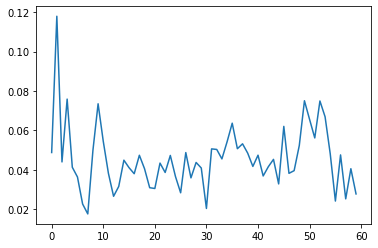

In [80]:
plt.plot(loss_values)

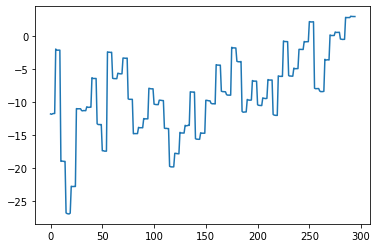

In [81]:
plt.plot(loss_policies)

In [83]:
observation

tensor([ 0.0000e+00,  8.2222e-01,  1.2246e-16, -1.0000e+00, -4.5880e-01,
         3.1809e-01, -8.6603e-01, -5.0000e-01, -1.0000e+00, -1.0000e+00,
         0.0000e+00,  1.0000e+00, -1.0000e+00, -1.0000e+00,  0.0000e+00,
         1.0000e+00, -1.0363e-01,  5.9415e-01,  0.0000e+00,  1.0000e+00,
        -1.0000e+00, -1.0000e+00,  0.0000e+00,  1.0000e+00], device='cuda:0')

In [90]:
list(policy.parameters())

[Parameter containing:
 tensor([[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]], device='cuda:0',
        requires_grad=True),
 Parameter containing:
 tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, n

In [84]:
policy(observation)

tensor([nan, nan, nan, nan, nan, nan], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

In [28]:
data['gae'][0]

tensor([3.8235e-01, 6.9762e-01, 7.4128e-01, 2.9270e-02, 8.3587e-02, 1.8198e-02,
        6.8271e-03, 1.8021e-02, 4.8586e-01, 2.1420e-01, 1.7268e-03, 2.2728e-03,
        5.4260e-03, 3.7001e-03, 1.1367e-01, 4.8583e-03, 1.8209e-01, 7.4309e-02,
        2.7997e-03, 8.6750e-04, 3.4431e-02, 1.8908e-03, 5.5186e-02, 1.3229e-01,
        1.5385e-02, 2.9386e-03, 1.3438e-03, 9.8189e-01, 2.1852e-01, 2.1765e-02,
        2.3808e-03, 1.2458e-03, 1.8427e-03, 1.2357e-02, 2.9949e-03, 3.4743e-03,
        4.4196e-03, 6.7387e-02, 4.3495e-02, 6.5765e-01, 8.8628e-03, 3.0114e-01,
        3.1846e-02, 2.3719e-03, 6.1361e-03, 7.5821e-02, 4.2542e-02, 8.0455e-03,
        1.3519e-02, 2.2640e-03, 2.9367e-03, 6.0410e-03, 3.8994e-03, 4.2244e-01,
        1.4379e-01, 3.0043e-03, 2.2706e-03, 8.8574e-03, 2.6185e-01, 2.8968e-01,
        2.3582e-03, 1.0108e-01, 1.0273e-02, 1.4060e-01, 2.7629e-03, 6.4749e-02,
        2.1305e-03, 1.2675e-03, 4.8234e-02, 2.9818e-03, 2.3608e-03, 6.5279e-04,
        1.0798e-03, 1.7783e-03, 1.0936e-

In [27]:
data['chosen_move']

tensor([[1., 4., 4., 5., 1., 1., 1., 0., 3., 0., 3., 5., 3., 5., 2., 0., 4., 1.,
         4., 5., 0., 4., 4., 1., 4., 4., 1., 0., 5., 4., 4., 0., 4., 1., 4., 2.,
         1., 4., 1., 0., 1., 0., 4., 5., 5., 5., 4., 0., 0., 0., 4., 3., 5., 5.,
         4., 0., 1., 3., 3., 5., 1., 1., 2., 1., 4., 2., 3., 3., 2., 4., 5., 2.,
         0., 0., 2., 0., 2., 5., 1., 4., 1., 3., 5., 1., 2., 0., 0., 2., 0., 2.,
         2., 2., 0., 2., 0., 2., 2., 5., 3., 2.]])

In [26]:
old_values.device

device(type='cuda', index=0)

In [ ]:
device

In [9]:
results

[-1, 1]

In [69]:
len(erm)

1214

In [67]:
new_probs

tensor([0.1775, 0.1418, 0.1555, 0.1769, 0.1842, 0.1641],
       grad_fn=<SelectBackward>)

In [18]:
np.atan2(state[2], state[3])

AttributeError: module 'numpy' has no attribute 'atan2'

In [ ]:
state.move()

In [4]:
state

tensor([ 8.0000e-01,  0.0000e+00, -1.0000e+00, -1.8370e-16, -8.0000e-01,
         0.0000e+00, -1.0000e+00, -1.8370e-16, -1.0000e+00, -1.0000e+00,
         0.0000e+00,  1.0000e+00, -1.0000e+00, -1.0000e+00,  0.0000e+00,
         1.0000e+00, -1.0000e+00, -1.0000e+00,  0.0000e+00,  1.0000e+00,
        -1.0000e+00, -1.0000e+00,  0.0000e+00,  1.0000e+00])

In [17]:
state

tensor([ 8.0000e-01,  0.0000e+00, -1.0000e+00, -1.8370e-16, -8.0000e-01,
         0.0000e+00, -1.0000e+00, -1.8370e-16, -1.0000e+00, -1.0000e+00,
         0.0000e+00,  1.0000e+00, -1.0000e+00, -1.0000e+00,  0.0000e+00,
         1.0000e+00, -1.0000e+00, -1.0000e+00,  0.0000e+00,  1.0000e+00,
        -1.0000e+00, -1.0000e+00,  0.0000e+00,  1.0000e+00])

In [11]:
torch.round?

In [2]:
play_shooter(
    your_choose_move=human_player,
    opponent_choose_move=choose_move_randomly,
    game_speed_multiplier=1,
    render=True,
    include_barriers=False,
    half_game_size=False,
)

1.0